In [1]:
import numpy as np 
from tqdm import tqdm
import cv2 
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import glob
import nibabel as nib
import re

import pydicom as dicom
import os
import numpy as np
import matplotlib.pyplot as plt
from dcmrtstruct2nii import dcmrtstruct2nii, list_rt_structs
import glob
import nibabel as nib

from scipy import ndimage
import csv

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Pre-processing
## Read images and RT-Structure in Dicom to Nifty

In [457]:
def n4_correction(im_input, output_im):
    command1 = ("C:/data/radiomics/release/N4BiasFieldCorrection.exe" ' -i ' + im_input + ' -o ' + output_im)
    os.system(command1)
    print(command1)

### This script is used to convert dicom series together with contour RT-structure to nifty format;
# then n4-correction (.exe wrote by Eric Carver) for better contrast;
# then radiomics feature extraction using "pyradiomics" (because batch mode well supported with this library)
# in addition, it also generates quality control pictures for the purpose of peer review
# in order for this script to work, please create a local folder(e.g. "C:/data/radiomics/") and export T2W + single-contour RTstruct from MIM into this folder
# Author: Weiwei Zong & Eric Carver
# 05/11/2020
#########################

for file in glob.glob("C:/data/radiomics/wn/*/*ADC*/"): ##
    ### first read from folder of T2W dicom series exported from MIM (medical image pre-processing software)
    img_path = file
    ### the folder for contours are named in a different way than images
    ### this part is to modify image folder to get contour folder
#     contour_folder = img_path
    img_path = img_path.replace('\\', '/')
#     contour_folder = contour_folder.replace('_MR_', '_RTst_')
#     contour_folder = contour_folder.replace('_t2.tse.tra_n19__00000', '_._n1__00000')

    temp = img_path.split('/')
    pt_id = temp[-2][0:7] # prostatex 14 # wn series 7
    print(temp)
    rt_prefix = pt_id + '_' + pt_id + '_' + 'RTst'
    print(rt_prefix)
    contour_folder = [filename for filename in os.listdir(temp[0]+'/'+temp[1]+'/'+temp[2]+'/'+temp[3]+'/'+temp[4]) if filename.startswith(rt_prefix)]
    contour_folder = temp[0]+'/'+temp[1]+'/'+temp[2]+'/'+temp[3]+'/'+temp[4]+'/'+contour_folder[0]

    print(contour_folder)
    ### make folder to store generated nifty files (C:/data/radiomics/nii_output/)
    ### images and contours in nifty format will be stored under folders named after each patient ID
    output_folder = os.path.join('C:/data/radiomics/wn_nii_output/', pt_id)
    os.mkdir(output_folder)

    ### loop for every patient
    for file1 in os.listdir(contour_folder):
        if file1.endswith(".dcm"):
            ### dicom to nifty
            ### calling python library "dcmrtstruct2nii"
            contour_file = os.path.join(contour_folder, file1)
            print(contour_file)
            dcmrtstruct2nii(
                contour_file,
                img_path,
                output_folder)
            os.chdir(output_folder)
            print(output_folder)
            ### n4 correction for better contrast
            ### calling .exe "n4_correction" wrote by Eric Carver
            ### the generated nifty files for both images and contour will be stored in the output folder
            n4_correction('image.nii.gz', 'ADC_biasCorrect.nii.gz')
            os.remove("image.nii.gz")

['C:', 'data', 'radiomics', 'wn', '2012-10__Studies', 'WN00050_WN00050_MR_2012-10-02_085932_._Res.Reg.ADC_n28__00000', '']
WN00050_WN00050_RTst
C:/data/radiomics/wn/2012-10__Studies/WN00050_WN00050_RTst_2012-10-02_085932_._._n1__00000
C:/data/radiomics/wn/2012-10__Studies/WN00050_WN00050_RTst_2012-10-02_085932_._._n1__00000\2.16.840.1.114362.1.6.7.6.17718.11897664413.549669117.595.18.dcm
C:/data/radiomics/wn_nii_output/WN00050
C:/data/radiomics/release/N4BiasFieldCorrection.exe -i image.nii.gz -o ADC_biasCorrect.nii.gz
['C:', 'data', 'radiomics', 'wn', '2013-01__Studies', 'WN00047_WN00047_MR_2013-01-24_111553_._Res.Reg.ADC_n36__00000', '']
WN00047_WN00047_RTst
C:/data/radiomics/wn/2013-01__Studies/WN00047_WN00047_RTst_2013-01-24_111553_._._n1__00000
C:/data/radiomics/wn/2013-01__Studies/WN00047_WN00047_RTst_2013-01-24_111553_._._n1__00000\2.16.840.1.114362.1.6.7.6.17718.13094212895.576373311.977.26.dcm
C:/data/radiomics/wn_nii_output/WN00047
C:/data/radiomics/release/N4BiasFieldCorrect

C:/data/radiomics/wn_nii_output/WN00031
C:/data/radiomics/release/N4BiasFieldCorrection.exe -i image.nii.gz -o ADC_biasCorrect.nii.gz
['C:', 'data', 'radiomics', 'wn', '2016-07__Studies', 'WN00001_WN00001_MR_2016-07-06_094303_._Res.Reg.ADC_n38__00000', '']
WN00001_WN00001_RTst
C:/data/radiomics/wn/2016-07__Studies/WN00001_WN00001_RTst_2016-07-06_094303_._._n1__00000
C:/data/radiomics/wn/2016-07__Studies/WN00001_WN00001_RTst_2016-07-06_094303_._._n1__00000\2.16.840.1.114362.1.6.7.6.17718.13094212895.576380422.1022.6.dcm
C:/data/radiomics/wn_nii_output/WN00001
C:/data/radiomics/release/N4BiasFieldCorrection.exe -i image.nii.gz -o ADC_biasCorrect.nii.gz
['C:', 'data', 'radiomics', 'wn', '2016-08__Studies', 'WN00003_WN00003_MR_2016-08-18_132650_._Res.Reg.ADC_n39__00000', '']
WN00003_WN00003_RTst
C:/data/radiomics/wn/2016-08__Studies/WN00003_WN00003_RTst_2016-08-18_132650_._._n1__00000
C:/data/radiomics/wn/2016-08__Studies/WN00003_WN00003_RTst_2016-08-18_132650_._._n1__00000\2.16.840.1.1143

C:/data/radiomics/wn_nii_output/WN00052
C:/data/radiomics/release/N4BiasFieldCorrection.exe -i image.nii.gz -o ADC_biasCorrect.nii.gz
['C:', 'data', 'radiomics', 'wn', '2017-02__Studies', 'WN00033_WN00033_MR_2017-02-02_111341_._Res.Reg.ADC_n40__00000', '']
WN00033_WN00033_RTst
C:/data/radiomics/wn/2017-02__Studies/WN00033_WN00033_RTst_2017-02-02_111341_._._n1__00000
C:/data/radiomics/wn/2017-02__Studies/WN00033_WN00033_RTst_2017-02-02_111341_._._n1__00000\2.16.840.1.114362.1.11987077.24450720399.578032817.544.61.dcm
C:/data/radiomics/wn_nii_output/WN00033
C:/data/radiomics/release/N4BiasFieldCorrection.exe -i image.nii.gz -o ADC_biasCorrect.nii.gz
['C:', 'data', 'radiomics', 'wn', '2017-03__Studies', 'WN00049_WN00049_MR_2017-03-02_063010_._Res.Reg.ADC_n39__00000', '']
WN00049_WN00049_RTst
C:/data/radiomics/wn/2017-03__Studies/WN00049_WN00049_RTst_2017-03-02_063010_._._n1__00000
C:/data/radiomics/wn/2017-03__Studies/WN00049_WN00049_RTst_2017-03-02_063010_._._n1__00000\2.16.840.1.114362.

# Pre-processing
## Crop a Rectangle around the Contour of Prostate/Peripheral Zone/Central Gland

(164, 226)
(240, 157)


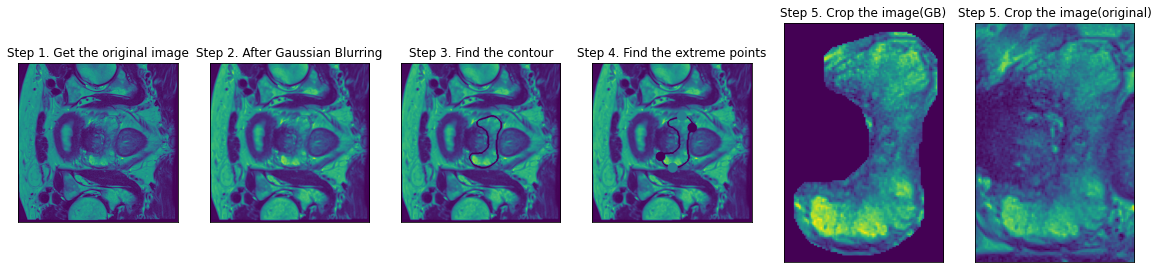

In [48]:
import cv2

gray = t2[:,:,10]/t2[:,:,10].max() * 255
gb = cv2.GaussianBlur(t2[:,:,10], (5, 5), 0)
thresh = ps[:,:,10]
dilation_uni = dilation / 255
crop = gray * dilation_uni
# print(gray.max())

# find contours in mask
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

print(extLeft)
print(extRight)

# add contour on the image
img_cnt = cv2.drawContours(gb.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 12, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 12, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 12, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 12, (255, 255, 0), -1)

# crop
ADD_PIXELS = 10
new_img = crop[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
new_img_test = gray[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# plot
plt.figure(figsize=(20,6))
plt.subplot(161)
plt.imshow(t2[:,:,10])
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(162)
plt.imshow(gb)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. After Gaussian Blurring')
plt.subplot(163)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the contour')
plt.subplot(164)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Find the extreme points')
plt.subplot(165)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. Crop the image(GB)')
plt.subplot(166)
plt.imshow(new_img_test)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. Crop the image(original)')
plt.show()

# Pre-processing
## Crop a Rectangle around the Contour of Prostate/Peripheral Zone/Central Gland
### Display one Patient

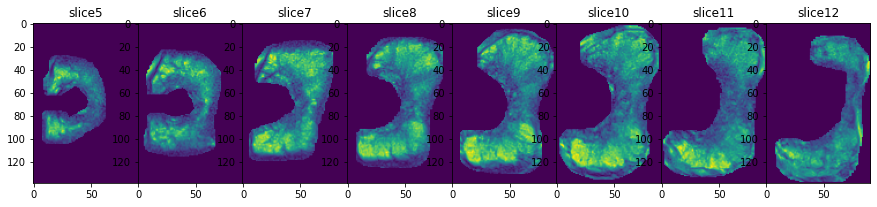

In [116]:
temp = 1
kernel = np.ones((10,10),np.uint8)
img_size = 150

# plot the croped prostate mri            
fig, axs = plt.subplots(1,8, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for slice_id in range(ps.shape[2]):
    if np.any(ps[:, :, slice_id]):
        thresh = ps[:,:,slice_id]
        
        dilation = cv2.dilate(thresh,kernel,iterations = 1)


# find contours in mask
        cnts = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

# find the extreme points on 1 slice
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        
        if temp:
            temp = 0
            final_extLeft = extLeft
            final_extRight = extRight
            final_extTop = extTop
            final_extBot = extBot
            
# find the extreme points of all the slices            
        if final_extLeft[0] > extLeft[0]: final_extLeft = extLeft 
        if final_extRight[0] < extRight[0]: final_extRight = extRight 
        if final_extTop[1] > extTop[1]: final_extTop = extTop 
        if final_extBot[1] < extBot[1]: final_extBot = extBot 


# crop
temp = 0
new_img = np.zeros((139, 91, 8))
for slice_id in range(ps.shape[2]):
    if np.any(ps[:, :, slice_id]):
        thresh = ps[:,:,slice_id]
        
        dilation = cv2.dilate(thresh,kernel,iterations = 1)
        
        dilation_uni = dilation / 255
        crop = t2[:, :, slice_id] * dilation_uni
        
        ADD_PIXELS = 2
        new_img[:,:,temp] = crop[final_extTop[1]-ADD_PIXELS:final_extBot[1]+ADD_PIXELS, final_extLeft[0]-ADD_PIXELS:final_extRight[0]+ADD_PIXELS].copy()

        
        
        
        axs[slice_id-5].imshow(new_img[:,:,temp])
        axs[slice_id-5].set_title('slice' + str(slice_id))
        
        temp += 1

plt.show()

# Pre-processing
## Generate .gif for each patient for Quality Assurance Purpose

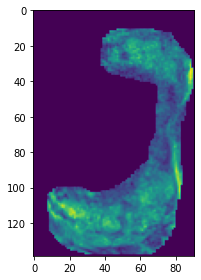

In [117]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# # Query the figure's on-screen size and DPI. Note that when saving the figure to
# # a file, we need to provide a DPI for that separately.
# print('fig size: {0} DPI, size in inches {1}'.format(
#     fig.get_dpi(), fig.get_size_inches()))

# # Plot a scatter that persists (isn't redrawn) and the initial line.
# x = np.arange(0, 20, 0.1)
# ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
# line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
#     label = 'timestep {0}'.format(i)
#     print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    ax.imshow(new_img[:,:,i])
    return ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 8), interval=300)
    anim.save('C:/data/radiomics/'+pt_id+'-pz.gif', dpi=80, writer='imagemagick')
    
        # plt.show() will just loop the animation forever.
    plt.show()

In [80]:
# Go through all the patients
for pt_folder in glob.glob('C:/data/radiomics/prostatex-nii/*'):
        temp = pt_folder.split('\\')
        pt_id = temp[-1] # prostatex 14
        print(pt_id)
    

ProstateX-0000
ProstateX-0001
ProstateX-0002
ProstateX-0004
ProstateX-0005
ProstateX-0007
ProstateX-0009
ProstateX-0012
ProstateX-0014
ProstateX-0015
ProstateX-0016
ProstateX-0018
ProstateX-0019
ProstateX-0020
ProstateX-0026
ProstateX-0028
ProstateX-0029
ProstateX-0031
ProstateX-0033
ProstateX-0035
ProstateX-0037
ProstateX-0039
ProstateX-0044
ProstateX-0046
ProstateX-0053
ProstateX-0054
ProstateX-0055
ProstateX-0056
ProstateX-0059
ProstateX-0060
ProstateX-0065
ProstateX-0066
ProstateX-0067
ProstateX-0069
ProstateX-0070
ProstateX-0071
ProstateX-0072
ProstateX-0076
ProstateX-0077
ProstateX-0078
ProstateX-0080
ProstateX-0082
ProstateX-0083
ProstateX-0084
ProstateX-0089
ProstateX-0090
ProstateX-0092
ProstateX-0094
ProstateX-0095
ProstateX-0096
ProstateX-0097
ProstateX-0099
ProstateX-0101
ProstateX-0102
ProstateX-0103
ProstateX-0104
ProstateX-0105
ProstateX-0106
ProstateX-0107
ProstateX-0110
ProstateX-0111
ProstateX-0112
ProstateX-0114
ProstateX-0115
ProstateX-0116
ProstateX-0117
ProstateX-

# Pre-processing
## Cropping Batch Mode

In [85]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def crop_imgs_25D(data_path, add_pixels_value=10, img_size=(150, 150), is_pz = 1):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    
    set_new = np.empty([150, 150, 3, 1])
    
    # read pt id
    gleason_df = pd.read_csv("C:/data/radiomics/Gleason-info.csv", na_values = ['no info', '.'])
    if is_pz == 1:
        pz = gleason_df[(gleason_df['zone'] == "PZ") | (gleason_df['zone'] == "NL")] 
    pz = gleason_df[(gleason_df['zone'] == "CG")  | (gleason_df['zone'] == "NL")]
        
    kernel = np.ones((10,10),np.uint8)
    print(len(pz))
    
    for pt_idx in range(len(pz)): ## pz or cg
        
        pt_id = pz['ProxID'][pz.index[pt_idx]] ## pz or cg
        print(pt_id)
        pt_folder = "C:/data/radiomics/prostatex-nii/" + pt_id


#         read mask into numpy
        # CG   
        for f in os.listdir(pt_folder):
            if re.match('mask_A', f): # AFS file matching
                mask_path = pt_folder + "/" + f
                mask1 = nib.load(mask_path)
                mask1 = np.array(mask1.dataobj)
       
        for f in os.listdir(pt_folder):
            if re.match('mask_T', f): # TZ file matching
                mask_path = pt_folder + "/" + f
                mask2 = nib.load(mask_path)
                mask2 = np.array(mask2.dataobj)
                
        for f in os.listdir(pt_folder):
            if re.match('mask_P', f): # PZ file matching
                mask_path = pt_folder + "/" + f
                mask3 = nib.load(mask_path)
                mask3 = np.array(mask3.dataobj)
                   
        mask_ps = mask1 + mask2 + mask3 # Prostate = Central Gland + Peripheral Zone
        mask_cg = mask1 + mask2 # Central Gland = AFS + Transitional Zone
        mask_pz = mask3 # Peripheral Zone
        
        central_index = int(pz['central_slice'][pz.index[pt_idx]])
        print(central_index)
        
        
        img = nib.load(pt_folder + "/biasCorrect.nii.gz") ##
        img = np.array(img.dataobj)
        
        # Calculate the Mean and Std of entire sequence
        loc = np.where(mask_ps==255) # find pixels location within the prostate contour
        print(np.shape(loc))
        print(img.shape)
        avg = np.mean(img[loc])
        dev = np.std(img[loc])
        img = (img - avg)/dev
##
# crop only 2.5D
        mask = mask_cg[:,:,(central_index - 1):(central_index + 2)]
        print(mask.shape)

        
 # read image into numpy   


        img = img[:,:,(central_index - 1):(central_index + 2)]
        
        print(img.shape)
        temp = 1
        for slice_id in range(mask.shape[2]):
            if np.any(mask[:, :, slice_id]):
                thresh = mask[:,:,slice_id]

# find contours in mask
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
                c = max(cnts, key=cv2.contourArea)

# find the extreme points on 1 slice
                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])
        
                if temp:
                    temp = 0
                    final_extLeft = extLeft
                    final_extRight = extRight
                    final_extTop = extTop
                    final_extBot = extBot
            
# find the extreme points of all the slices            
                if final_extLeft[0] > extLeft[0]: final_extLeft = extLeft 
                if final_extRight[0] < extRight[0]: final_extRight = extRight 
                if final_extTop[1] > extTop[1]: final_extTop = extTop 
                if final_extBot[1] < extBot[1]: final_extBot = extBot 
                    
# option 1: crop only prostate

        new_img = np.zeros((150, 150, 3))
        slice_idd = 0
        for slice_id in range(mask.shape[2]):
            if np.any(mask[:, :, slice_id]):
#                 gb = cv2.GaussianBlur(img[:,:,slice_id], (5, 5), 0)
                thresh = mask[:,:,slice_id]
                dilation = cv2.dilate(thresh,kernel,iterations = 1)
                dilation_uni = dilation / 255
                crop = img[:, :, slice_id] * dilation_uni 
                
# option 2: no cropping
#                 crop = img[:, :, slice_id]

# crop
                ADD_PIXELS = 10
                gb_temp = crop[final_extTop[1]-ADD_PIXELS:final_extBot[1]+ADD_PIXELS, final_extLeft[0]-ADD_PIXELS:final_extRight[0]+ADD_PIXELS].copy()
                gb_temp = cv2.resize(
                    gb_temp,
                    dsize=img_size,
                    interpolation=cv2.INTER_CUBIC
                )
                
                new_img[:,:,slice_idd] = gb_temp
                slice_idd += 1 
             
                
                # Generate QA .gif
        
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        def update(i):
            ax.imshow(new_img[:,:,i])
            return ax
        anim = FuncAnimation(fig, update, frames=np.arange(0, new_img.shape[-1]), interval=500)
        anim.save('C:/data/radiomics/QA-two-point-five-D-slices/'+pt_id+'-25D-t2-cg.gif', dpi=80, writer='imagemagick')
        plt.close(fig)       
        
        new_img = np.expand_dims(new_img, axis=-1)       
        set_new = np.append(set_new, new_img, axis = -1)     
 

    print(set_new.shape)
    return np.array(set_new[:,:,:,1:])

In [86]:
# apply this for the set of T2W images
X_train_t2_cg = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*", is_pz = 0)

97
ProstateX-0001
8
(3, 36146)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0004
7
(3, 141909)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0007
9
(3, 94547)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0009
9
(3, 102611)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0012
9
(3, 63227)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0014
7
(3, 31225)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0015
8
(3, 72588)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0016
5


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 137740)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0018
5
(3, 77060)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(3, 85662)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0026
7
(3, 72085)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0029
9
(3, 88408)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(3, 81123)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0035
10
(3, 92490)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0037
8
(3, 48142)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0039
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 115613)
(384, 384, 24)
(384, 384, 3)
(384, 384, 3)
ProstateX-0044
9
(3, 99751)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0055
9
(3, 81555)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(3, 93129)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(3, 93522)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0060
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 223513)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0065
9
(3, 50021)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(3, 120746)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(3, 151386)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0071
12
(3, 44222)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0072
9
(3, 79207)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0078
8
(3, 38020)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0080
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 150249)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0082
14
(3, 46807)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(3, 39092)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0089
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 126880)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0090
9
(3, 92647)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0092
8
(3, 28259)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0094
7
(3, 32474)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 96311)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0097
11
(3, 50102)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0101
4
(3, 49342)
(320, 320, 19)
(320, 320, 3)
(320, 320, 3)
ProstateX-0102
4
(3, 84276)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0104
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 84232)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0105
7
(3, 65554)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0106
6
(3, 64470)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(3, 119890)
(320, 320, 23)
(320, 320, 3)
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0110
5
(3, 92131)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0111
10
(3, 44353)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0112
9
(3, 90442)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0114
10
(3, 50722)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0115
13
(3, 26473)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0118
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 52970)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0119
7
(3, 90094)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0120
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 129965)
(384, 384, 25)
(384, 384, 3)
(384, 384, 3)
ProstateX-0121
8


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 101186)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0122
11
(3, 86515)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0125
11
(3, 49114)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0126
7
(3, 97337)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0130
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 123207)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0131
11
(3, 53775)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0133
10
(3, 37563)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0134
9
(3, 71697)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0136
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 71721)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(3, 55471)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0142
13
(3, 122980)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0143
7
(3, 68394)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0144
9
(3, 49143)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0145
12


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 61450)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0146
9
(3, 153944)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0148
3
(3, 71790)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0150
12
(3, 69450)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0152
9
(3, 40411)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0153
7


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 77079)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0154
9
(3, 103136)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0156
9
(3, 119625)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 172627)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0162
6
(3, 132515)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0164
11
(3, 32812)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0165
6
(3, 125677)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0168
6
(3, 62634)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0169
10
(3, 36542)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0170
9
(3, 75444)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0172
2


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 108810)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0173
13
(3, 70188)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0174
9
(3, 103455)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(3, 54623)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0177
9
(3, 25061)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0179
13


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 70631)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0180
9
(3, 82755)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0181
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 433338)
(640, 640, 25)
(640, 640, 3)
(640, 640, 3)
ProstateX-0186
6
(3, 36620)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0187
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 90903)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0188
13
(3, 57880)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0191
10
(3, 70787)
(384, 384, 18)
(384, 384, 3)
(384, 384, 3)
ProstateX-0194
5
(3, 124773)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0195
5


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 50029)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0197
6
(3, 52809)
(384, 384, 19)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0198
7
(3, 51576)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0199
8
(3, 61886)
(320, 320, 19)

MovieWriter imagemagick unavailable; using Pillow instead.



(320, 320, 3)
(320, 320, 3)
ProstateX-0201
8


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 60729)
(320, 320, 23)
(320, 320, 3)
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0202
12
(3, 47157)
(320, 320, 21)
(320, 320, 3)
(320, 320, 3)
(150, 150, 3, 98)


In [84]:
# apply this for the set of ADC images
X_train_adc_cg = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*", is_pz = 0)

MovieWriter imagemagick unavailable; using Pillow instead.


97
ProstateX-0001
8
(3, 36146)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0004
7
(3, 141909)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0007
9
(3, 94547)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(3, 102611)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(3, 63227)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0014
7
(3, 31225)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0015
8
(3, 72588)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0016
5
(3, 137740)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0018
5
(3, 77060)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(3, 85662)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0026
7
(3, 72085)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(3, 88408)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(3, 81123)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0035
10
(3, 92490)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0037
8
(3, 48142)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0039
9
(3, 115613)
(384, 384, 24)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(3, 99751)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0055
9
(3, 81555)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(3, 93129)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(3, 93522)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0060
9
(3, 223513)
(384, 384, 23)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(3, 50021)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(3, 120746)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0070
9
(3, 151386)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0071
12
(3, 44222)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0072
9
(3, 79207)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0078
8
(3, 38020)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0080
9
(3, 150249)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0082
14
(3, 46807)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(3, 39092)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0089
9
(3, 126880)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(3, 92647)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0092
8
(3, 28259)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0094
7
(3, 32474)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0096
9
(3, 96311)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0097
11
(3, 50102)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0101
4
(3, 49342)
(320, 320, 19)
(320, 320, 3)
(320, 320, 3)
ProstateX-0102
4
(3, 84276)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0104
11
(3, 84232)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0105
7
(3, 65554)
(384, 384, 21)
(384, 384, 3)

MovieWriter imagemagick unavailable; using Pillow instead.



(384, 384, 3)
ProstateX-0106
6
(3, 64470)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(3, 119890)
(320, 320, 23)
(320, 320, 3)
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0110
5
(3, 92131)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0111
10
(3, 44353)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(3, 90442)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0114
10
(3, 50722)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0115
13
(3, 26473)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0118
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 52970)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0119
7
(3, 90094)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0120
9
(3, 129965)
(384, 384, 25)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0121
8
(3, 101186)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0122
11
(3, 86515)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0125
11
(3, 49114)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0126
7


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 97337)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0130
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 123207)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0131
11
(3, 53775)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0133
10
(3, 37563)
(384, 384, 21)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0134
9


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 71697)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0136
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 71721)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0139
6


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 55471)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0142
13


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 122980)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0143
7
(3, 68394)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(3, 49143)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0145
12
(3, 61450)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(3, 153944)
(384, 384, 21)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
ProstateX-0148
3
(3, 71790)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0150
12
(3, 69450)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0152
9
(3, 40411)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0153
7


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 77079)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(3, 103136)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0156
9
(3, 119625)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0161
9
(3, 172627)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)
ProstateX-0162
6
(3, 132515)
(384, 384, 19)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0164
11
(3, 32812)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0165
6
(3, 125677)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0168
6
(3, 62634)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0169
10


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 36542)
(384, 384, 23)
(384, 384, 3)
(384, 384, 3)
ProstateX-0170
9
(3, 75444)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0172
2
(3, 108810)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0173
13
(3, 70188)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0174
9
(3, 103455)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(3, 54623)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(3, 25061)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0179
13
(3, 70631)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(3, 82755)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0181
11


MovieWriter imagemagick unavailable; using Pillow instead.


(3, 433338)
(640, 640, 25)
(640, 640, 3)
(640, 640, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0186
6
(3, 36620)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)
ProstateX-0187
11
(3, 90903)
(384, 384, 23)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
13
(3, 57880)
(384, 384, 21)
(384, 384, 3)
(384, 384, 3)
ProstateX-0191
10
(3, 70787)
(384, 384, 18)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0194
5
(3, 124773)
(384, 384, 21)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


(384, 384, 3)
ProstateX-0195
5
(3, 50029)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0197
6
(3, 52809)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0198
7
(3, 51576)
(384, 384, 19)
(384, 384, 3)
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0199
8
(3, 61886)
(320, 320, 19)
(320, 320, 3)
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0201
8
(3, 60729)
(320, 320, 23)
(320, 320, 3)
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0202
12
(3, 47157)
(320, 320, 21)
(320, 320, 3)
(320, 320, 3)
(150, 150, 3, 98)


In [41]:
# apply this for each set
X_train_adc_pz = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*", is_pz = 1)

MovieWriter imagemagick unavailable; using Pillow instead.


70
ProstateX-0000
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0005
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0007
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0009
9
(384, 384, 3)
ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0019
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0028
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0031
16
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0046
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0053
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0067
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0069
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)
ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0076
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0077
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0084
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0095
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0099
10
(384, 384, 3)
ProstateX-0103
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0116
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0117
14
(384, 384, 3)
ProstateX-0120
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0121
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0123
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0124
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0127
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0128
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(384, 384, 3)
ProstateX-0156
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)
ProstateX-0173
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0182
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0183
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0184
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0190
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0192
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0193
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0196
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0200
10
(320, 320, 3)
(150, 150, 3, 71)


In [43]:
# apply this for each set
X_train_t2_pz = crop_imgs_25D(data_path="C:/data/radiomics/prostatex-nii/*", is_pz = 1)

MovieWriter imagemagick unavailable; using Pillow instead.


70
ProstateX-0000
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
12
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0002
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0005
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0007
9
(384, 384, 3)
ProstateX-0009
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0012
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0019
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0020
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0028
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0029
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0031
16
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0033
9
(384, 384, 3)
ProstateX-0039
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0044
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0046
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0053
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0056
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0059
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0060
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0065
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0066
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0067
9
(384, 384, 3)
ProstateX-0069
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0070
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0072
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0076
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0077
10
(384, 384, 3)
ProstateX-0080
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0083
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0084
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0089
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0090
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0095
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0096
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0099
10
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0103
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0107
9
(320, 320, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0112
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0116
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0117
14
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0120
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0121
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0123
9
(384, 384, 3)
ProstateX-0124
13
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0127
8
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0128
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0130
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0134
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0139
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0144
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0146
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0154
9
(384, 384, 3)
ProstateX-0156
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0161
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0170
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0173
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0176
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0177
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0180
9
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0182
4
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0183
2
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0184
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0188
11
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0190
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0192
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0193
7
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0195
5
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0196
6
(384, 384, 3)


MovieWriter imagemagick unavailable; using Pillow instead.


ProstateX-0200
10
(320, 320, 3)
(150, 150, 3, 71)


In [90]:
# Note that ggg ==0 represents those cases that did not have biopsy test so no Gleason scores available
import pandas as pd
gleason_df = pd.read_csv("C:/data/radiomics/Gleason-info.csv", na_values = ['no info', '.'])
print(gleason_df.head(10))
print(len(gleason_df.index))

           ProxID  fid                                                pos  \
0  ProstateX-0000  1.0                            25.7457 31.8707 -38.511   
1  ProstateX-0001  1.0  -40.5367071921656 29.320722668457 -16.70766907...   
2  ProstateX-0002  1.0                          -27.0102 41.5467 -26.0469   
3  ProstateX-0002  2.0                            -2.058 38.6752 -34.6104   
4  ProstateX-0004  1.0                           -7.69665 3.64226 23.1659   
5  ProstateX-0005  1.0                           -38.6276 42.2781 21.4084   
6  ProstateX-0007  NaN                                                NaN   
7  ProstateX-0009  NaN                                                NaN   
8  ProstateX-0012  NaN                                                NaN   
9  ProstateX-0014  1.0                           -23.0672 31.7673 3.02353   

  zone  ggg  central_slice Unnamed: 6 Unnamed: 7  
0   PZ    3              9        NaN        NaN  
1   CG    1              8        NaN        NaN  

In [91]:
cg = gleason_df[(gleason_df['zone'] == "CG") | (gleason_df['zone'] == "NL")]
cg.head(5)

,ProxID,fid,pos,zone,ggg,central_slice,Unnamed: 6,Unnamed: 7
1,ProstateX-0001,1.0,-40.5367071921656 29.320722668457 -16.70766907...,CG,1,8,NaN,NaN
4,ProstateX-0004,1.0,-7.69665 3.64226 23.1659,CG,1,7,NaN,NaN
6,ProstateX-0007,NaN,NaN,NL,0,9,NaN,NaN
7,ProstateX-0009,NaN,NaN,NL,0,9,NaN,NaN
8,ProstateX-0012,NaN,NaN,NL,0,9,NaN,NaN


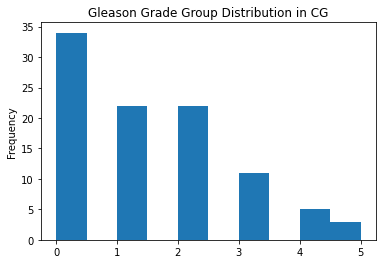

In [89]:
cg['ggg'] = cg['ggg'].astype(float)
cg['ggg'].dtype
cg['ggg'].plot(kind='hist', title='Gleason Grade Group Distribution in CG');

In [93]:
pz = gleason_df[(gleason_df['zone'] == "PZ") | (gleason_df['zone'] == "NL")] 
pz.head(5)

,ProxID,fid,pos,zone,ggg,central_slice,Unnamed: 6,Unnamed: 7
0,ProstateX-0000,1.0,25.7457 31.8707 -38.511,PZ,3,9,NaN,NaN
2,ProstateX-0002,1.0,-27.0102 41.5467 -26.0469,PZ,2,12,NaN,NaN
3,ProstateX-0002,2.0,-2.058 38.6752 -34.6104,PZ,1,9,NaN,NaN
5,ProstateX-0005,1.0,-38.6276 42.2781 21.4084,PZ,3,9,NaN,NaN
6,ProstateX-0007,NaN,NaN,NL,0,9,NaN,NaN


C:\Users\wzong1\Anaconda3\envs\gleason36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



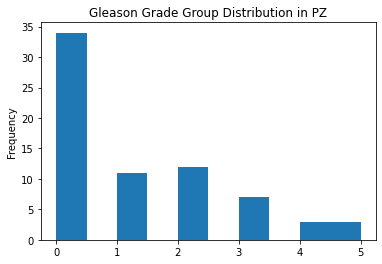

In [94]:
pz['ggg'] = pz['ggg'].astype(float)
pz['ggg'].dtype
pz['ggg'].plot(kind='hist', title='Gleason Grade Group Distribution in PZ');

In [76]:
len(pz)

70

In [90]:
len(cg)

97

In [78]:
pt_list = pz['ProxID']
label_list = pz['ggg']
# print(pt_list.index)
for row_id in pt_list.index:
    pt_id = pt_list[row_id]
    data_path = 'C:/data/radiomics/prostatex-nii/' + pt_id + '/biasCorrect.nii.gz'
    label = label_list[row_id]
    print(data_path)

C:/data/radiomics/prostatex-nii/ProstateX-0000/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0002/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0002/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0005/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0007/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0009/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0012/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0019/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0020/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0028/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0029/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0031/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0033/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0039/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0044/biasCorrect.nii.gz
C:/data/ra

In [91]:
pt_list = cg['ProxID']
label_list = cg['ggg']
# print(pt_list.index)
for row_id in pt_list.index:
    pt_id = pt_list[row_id]
    data_path = 'C:/data/radiomics/prostatex-nii/' + pt_id + '/biasCorrect.nii.gz'
    label = label_list[row_id]
    print(data_path)

C:/data/radiomics/prostatex-nii/ProstateX-0001/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0004/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0007/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0009/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0012/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0014/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0015/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0016/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0018/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0020/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0026/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0029/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0033/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0035/biasCorrect.nii.gz
C:/data/radiomics/prostatex-nii/ProstateX-0037/biasCorrect.nii.gz
C:/data/ra

In [92]:
print(len(np.asarray(label_list)))

97


# Pre-processing
## save into numpy

In [95]:
np.savez('C:/data/radiomics/train_cg_25D_97pt.npz', t2=X_train_t2_cg, adc=X_train_adc_cg, label = label_list.astype(int))

In [82]:
np.savez('C:/data/radiomics/train_pz_25D_70pt.npz', t2=X_train_t2_pz, adc=X_train_adc_pz, label = label_list.astype(int))

# Check Saved Numpy

In [97]:
data = np.load('C:/data/radiomics/train_pz_25D_70pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)

(150, 150, 3, 70)
(150, 150, 3, 70)
(70,)


3


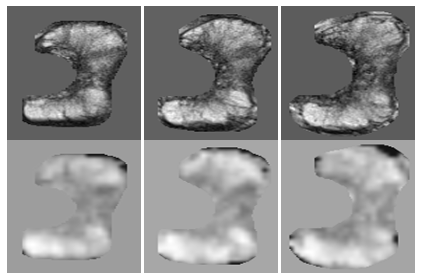

In [98]:
t2 = data['t2']
adc = data['adc']
label = data['label']
print(label[0])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,0], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,0], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,0], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,0], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,0], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,0], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

0


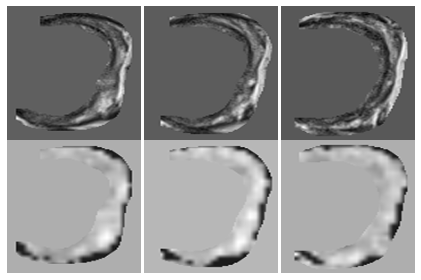

In [99]:
print(label[5])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,5], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,5], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,5], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,5], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,5], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,5], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

0


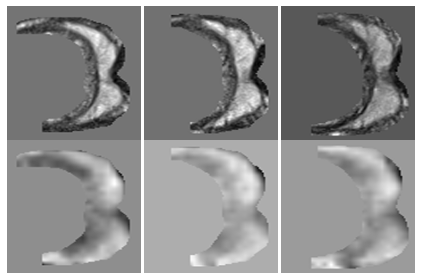

In [101]:
print(label[10])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,10], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,10], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,10], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,10], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,10], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,10], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [102]:
data = np.load('C:/data/radiomics/train_cg_25D_97pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)

(150, 150, 3, 97)
(150, 150, 3, 97)
(97,)


1


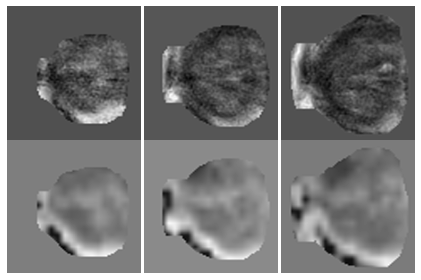

In [104]:
t2 = data['t2']
adc = data['adc']
label = data['label']
print(label[0])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,0], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,0], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,0], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,0], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,0], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,0], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

2


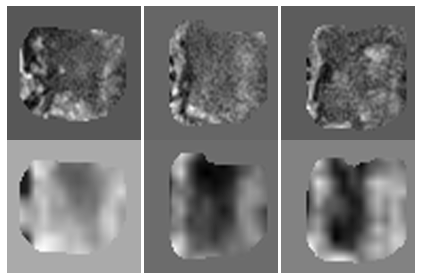

In [105]:
print(label[5])
fig, axs = plt.subplots(2, 3, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0, 0].imshow(t2[:,:,0,5], cmap='gray')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(t2[:,:,1,5], cmap='gray')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(t2[:,:,2,5], cmap='gray')
axs[0, 2].set_axis_off()
axs[1, 0].imshow(adc[:,:,0,5], cmap='gray')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(adc[:,:,1,5], cmap='gray')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(adc[:,:,2,5], cmap='gray')
axs[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [106]:
np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1).shape

(97, 150, 150, 3)

In [107]:
np.amax(np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1))

8.165158206288295

# Auto-Keras Training of 0-1 vs 2-5
## Calculate weight on different labels

In [109]:
data = np.load('C:/data/radiomics/train_cg_25D_97pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
print (data['label'].shape)
label = data['label']
t2 = data['t2']
adc = data['adc']

(150, 150, 3, 97)
(150, 150, 3, 97)
(97,)


In [153]:
print(label)

[1 1 0 0 0 2 3 1 2 0 4 0 0 2 2 0 0 3 0 0 0 0 0 0 3 0 3 0 2 0 0 0 3 3 0 2 1
 2 2 2 3 0 1 2 0 3 2 2 2 0 1 1 2 4 0 5 1 0 1 2 1 2 0 1 0 2 1 1 1 0 0 0 1 3
 1 1 3 0 1 1 1 0 0 2 0 5 2 3 1 1 2 4 2 5 4 2 4]


In [110]:
label[label==0]=0
label[label==1]=0
label[label==2]=1
label[label==3]=1
label[label==4]=1
label[label==5]=1
print(label)

[0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0
 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1]


In [111]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

pos1 = np.sum(label==0)
pos2 = np.sum(label==1)

total = pos1 + pos2 


weight_for_0 = (1 / pos1)*(total)/2.0
weight_for_1 = (1 / pos2)*(total)/2.0 


class_weight = {0: weight_for_0, 1: weight_for_1}


print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.87
Weight for class 1: 1.18


## multi-class case (optional)

In [146]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# pos0 = np.sum(data['label']==0)
pos1 = np.sum(data['label']==1)
pos2 = np.sum(data['label']==2)
pos3 = np.sum(data['label']==3)
# pos4 = np.sum(data['label']==4)
# pos5 = np.sum(data['label']==5)
total = pos1 + pos2 + pos3 

# weight_for_0 = 1
weight_for_1 = (1 / pos1)*(total)/2.0
weight_for_2 = (1 / pos2)*(total)/2.0 
weight_for_3 = (1 / pos3)*(total)/2.0
# weight_for_4 = (1 / pos4)*(total)/2.0 
# weight_for_5 = (1 / pos5)*(total)/2.0

class_weight = {0: weight_for_1, 1: weight_for_2, 2: weight_for_3}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
# print('Weight for class 4: {:.2f}'.format(weight_for_4))
# print('Weight for class 5: {:.2f}'.format(weight_for_5))

Weight for class 1: 1.36
Weight for class 2: 1.25
Weight for class 3: 2.14


# Auto-Keras Training of 0-1 vs 2-5
## PZ/CG
### Input construction

In [125]:
adcslice = np.swapaxes(np.swapaxes(np.swapaxes(adc, 2, 3), 1, 2), 0, 1)
adc0slice = adcslice[:,:,:,0]
adc0slice = np.expand_dims(adc0slice, axis=-1)
adc1slice = adcslice[:,:,:,1]
adc1slice = np.expand_dims(adc1slice, axis=-1)
adc2slice = adcslice[:,:,:,2]
adc2slice = np.expand_dims(adc2slice, axis=-1)
print(adc1slice.shape)


t2slice = np.swapaxes(np.swapaxes(np.swapaxes(t2, 2, 3), 1, 2), 0, 1)
t20slice = t2slice[:,:,:,0]
t21slice = t2slice[:,:,:,1]
t22slice = t2slice[:,:,:,2]
t20slice = np.expand_dims(t20slice, axis=-1)
t21slice = np.expand_dims(t21slice, axis=-1)
t22slice = np.expand_dims(t22slice, axis=-1)
print(t21slice.shape)

t2adc1slice = np.concatenate((t21slice, adc1slice), axis=-1)
print(t2adc1slice.shape)

(97, 150, 150, 1)
(97, 150, 150, 1)
(97, 150, 150, 2)


In [126]:
t211slice = np.concatenate((t21slice, t21slice), axis=-1)
adc11slice = np.concatenate((adc1slice, adc1slice), axis=-1)
print(t211slice.shape)

(97, 150, 150, 2)


In [127]:
t201slice = np.concatenate((t20slice, t21slice), axis=-1)
t212slice = np.concatenate((t21slice, t22slice), axis=-1)
print(t212slice.shape)

(97, 150, 150, 2)


In [128]:
adc01slice = np.concatenate((adc0slice, adc1slice), axis=-1)
adc12slice = np.concatenate((adc1slice, adc2slice), axis=-1)
print(adc01slice.shape)

(97, 150, 150, 2)


## Input Augmentation of bi-modality 
### T2-ADC Pair; T2-neighboring Pair; ADC-neighboring Pair

In [129]:
mix = np.concatenate((t2adc1slice, adc01slice, adc12slice, t201slice, t212slice), axis=0)
# mix = np.concatenate((mix, adc2slice), axis=0)
print(mix.shape)

(485, 150, 150, 2)


In [130]:
label_mix = np.concatenate((label, label, label, label, label), axis=0)
label_mix.shape

(485,)

# Auto-Keras Training of 0-1 vs 2-5
## T2-ADC Pair

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step
    
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    normalize=False,
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    metrics=[AUC(name='auc')],
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    tuner="bayesian",
    seed=None,)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(t2adc1slice, label, test_size=0.33, shuffle= True)
my_callbacks = [EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)]

# fit
reg.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=None, callbacks=my_callbacks, class_weight=class_weight)

# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/binary/01vs2345/cg/t2adc1slice", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/binary/01vs2345/cg/t2adc1slice/model_autokeras.h5")

Trial 20 Complete [00h 00m 16s]
val_loss: 0.6931939125061035

Best val_loss So Far: 0.6229844093322754
Total elapsed time: 00h 08m 57s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets
<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/binary/01vs2345/cg/t2adc1slice\assets


In [63]:
from tensorflow.keras.models import load_model

model = load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/t2adc1slice", custom_objects=ak.CUSTOM_OBJECTS)
# model = reg.export_model()

predicted_y = model.predict(t2adc1slice)
print(predicted_y)

model.summary()
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(predicted_y, label)
print("rms error is: " + str(rmse_val))


for name, value in zip(model.metrics_names, predicted_y):
    print(name, ': ', value)
print()

[[0.5521786 ]
 [0.2282362 ]
 [0.45033786]
 [0.20979983]
 [0.5288244 ]
 [0.6402449 ]
 [0.43927032]
 [0.40817496]
 [0.36539268]
 [0.17767599]
 [0.5944597 ]
 [0.29114997]
 [0.45717046]
 [0.26237792]
 [0.4966224 ]
 [0.23181823]
 [0.35995352]
 [0.715932  ]
 [0.17195116]
 [0.27289155]
 [0.17269112]
 [0.5764028 ]
 [0.18925847]
 [0.167377  ]
 [0.4914213 ]
 [0.2925494 ]
 [0.58112705]
 [0.23610775]
 [0.4031945 ]
 [0.6185957 ]
 [0.39919758]
 [0.2568938 ]
 [0.69698524]
 [0.71404517]
 [0.3212247 ]
 [0.4674165 ]
 [0.4590936 ]
 [0.6661986 ]
 [0.37892   ]
 [0.4389069 ]
 [0.5188898 ]
 [0.14011805]
 [0.40673688]
 [0.45471215]
 [0.25255197]
 [0.43010667]
 [0.54511917]
 [0.41972947]
 [0.3308467 ]
 [0.14584415]
 [0.2706921 ]
 [0.30592236]
 [0.29965708]
 [0.47370106]
 [0.4068828 ]
 [0.3731445 ]
 [0.55608076]
 [0.3473049 ]
 [0.45068854]
 [0.662729  ]
 [0.20194095]
 [0.5798718 ]
 [0.5450081 ]
 [0.4365585 ]
 [0.17823827]
 [0.6657992 ]
 [0.27344528]
 [0.6892728 ]
 [0.46189183]
 [0.11799616]
 [0.23352309]
 [0.32

# Auto-Keras Training of 0-1 vs 2-5
## Mixture of Input Pairs

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
import autokeras as ak
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC

def save_model(self, trial_id, model, step=0):
    epoch = step
    self._checkpoint_model(model, trial_id, epoch)
    # TODO: save the top epoch checkpoints instead of last ones.
    epoch_to_delete = epoch - self._save_n_checkpoints
    best_epoch = self.oracle.get_trial(trial_id).best_step


input_node = ak.ImageInput()
output_node = ak.ImageBlock(

    normalize=False,
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    metrics=[AUC(name='auc')],
    project_name="gleason-no-augmentation",
    max_trials=20,
    directory="C:/data/radiomics",
    tuner="bayesian",
    seed=None,)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(mix, label_mix, test_size=0.33, shuffle= True)
my_callbacks = [EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)]

# fit
reg.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=None, callbacks=my_callbacks, class_weight=class_weight)

# Export as a Keras Model.
model = reg.export_model()

print(type(model))  # <class 'tensorflow.python.keras.engine.training.Model'>

try:
    model.save("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", save_format="tf")
except:
    model.save("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix/model_autokeras.h5")

Trial 20 Complete [00h 00m 56s]
val_loss: 0.6953954696655273

Best val_loss So Far: 0.518682599067688
Total elapsed time: 00h 23m 37s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: C:/data/radiomics\gleason-no-augmentation\best_model\assets
<class 'tensorflow.python.keras.engine.functional.Functional'>
INFO:tensorflow:Assets written to: C:/data/radiomics/saved_model/binary/01vs2345/cg/mix\assets


In [65]:
from tensorflow.keras.models import load_model

model = load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
# model = reg.export_model()

predicted_y = model.predict(mix)
print(predicted_y)

model.summary()
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(predicted_y, label_mix)
print("rms error is: " + str(rmse_val))


for name, value in zip(model.metrics_names, predicted_y):
    print(name, ': ', value)
print()

[[6.16120808e-02]
 [3.10131069e-02]
 [3.84348407e-02]
 [5.08540981e-02]
 [6.66787386e-01]
 [6.72145009e-01]
 [8.05602312e-01]
 [1.74745414e-02]
 [6.21567845e-01]
 [7.42770825e-03]
 [9.36131299e-01]
 [4.26236121e-03]
 [7.36598521e-02]
 [8.56946826e-01]
 [5.96073151e-01]
 [2.30596657e-03]
 [7.30155557e-02]
 [9.76629555e-01]
 [1.33975176e-03]
 [7.44640827e-01]
 [6.06334247e-02]
 [5.51970117e-02]
 [1.35770038e-01]
 [3.79287521e-03]
 [5.19332647e-01]
 [7.42592569e-03]
 [9.38506782e-01]
 [1.03407621e-01]
 [9.03239727e-01]
 [5.18405855e-01]
 [1.90763883e-02]
 [2.62488835e-02]
 [8.31685543e-01]
 [9.44729447e-01]
 [1.66080240e-02]
 [8.04108143e-01]
 [1.78388178e-01]
 [9.58166838e-01]
 [8.79137397e-01]
 [5.82119524e-01]
 [9.13481653e-01]
 [1.12725981e-03]
 [6.35237396e-01]
 [8.36444974e-01]
 [2.25321110e-02]
 [9.58781123e-01]
 [6.39260352e-01]
 [9.32260096e-01]
 [8.78607213e-01]
 [5.30044024e-04]
 [7.50939026e-02]
 [1.03781614e-02]
 [3.60066563e-01]
 [9.37158942e-01]
 [1.02612674e-02]
 [5.243129

In [66]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(label_mix, predicted_y, pos_label=1)
print(fpr)
print(tpr)
metrics.auc(fpr, tpr)

[0.         0.         0.         0.00357143 0.00357143 0.00714286
 0.00714286 0.01428571 0.01428571 0.01785714 0.01785714 0.02142857
 0.02142857 0.02857143 0.02857143 0.03214286 0.03214286 0.03571429
 0.03571429 0.03928571 0.03928571 0.04285714 0.04285714 0.04642857
 0.04642857 0.05357143 0.05357143 0.05714286 0.05714286 0.06071429
 0.06071429 0.06428571 0.06428571 0.06785714 0.06785714 0.07142857
 0.07142857 0.075      0.075      0.08571429 0.08571429 0.09285714
 0.09285714 0.09642857 0.09642857 0.1        0.1        0.10357143
 0.10357143 0.11071429 0.11071429 0.11428571 0.11428571 0.11785714
 0.11785714 0.12142857 0.12142857 0.12857143 0.12857143 0.13214286
 0.13214286 0.15714286 0.15714286 0.16071429 0.16071429 0.17857143
 0.17857143 0.18571429 0.18571429 0.20714286 0.20714286 0.22857143
 0.22857143 0.23214286 0.23214286 0.24642857 0.24642857 0.26071429
 0.26071429 0.26785714 0.26785714 0.35357143 0.35357143 0.375
 0.375      0.43571429 0.43571429 0.57857143 0.57857143 0.63571429


0.9492682926829268

# Model Visulization Grad-CAM


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## The Grad-CAM Algorithm

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## load private data

In [5]:
data = np.load('C:/data/radiomics/wn_prostate_norm_crop.npz')
print (data['t2'].shape)
print (data['adc'].shape)
t2 = data['t2']
adc = data['adc']
# print (data['label'].shape)
# adc = np.swapaxes(np.swapaxes(np.swapaxes(data['adc'], 2, 3), 1, 2), 0, 1)
# t2 = np.swapaxes(np.swapaxes(np.swapaxes(data['t2'], 2, 3), 1, 2), 0, 1)
print(adc.shape)
label = data['label']

(150, 150, 40, 40)
(150, 150, 40, 40)
(150, 150, 40, 40)


## load training data

In [135]:
data = np.load('C:/data/radiomics/train_pz_25D_70pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
t2 = data['t2']
adc = data['adc']
label = data['label']

(150, 150, 3, 70)
(150, 150, 3, 70)


In [124]:
data = np.load('C:/data/radiomics/train_cg_25D_97pt.npz')
print (data['t2'].shape)
print (data['adc'].shape)
t2 = data['t2']
adc = data['adc']
label = data['label']

(150, 150, 3, 97)
(150, 150, 3, 97)


## display model layers to get the last-conv name

In [78]:
from tensorflow.keras.models import load_model
import autokeras as ak
# Make model
model = load_model("C:/data/radiomics/saved_model/pz_detector/01vs2345")


X = tf.random.uniform(shape=(1, 150, 150, 2))
for layer in model.layers:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

input_1 output shape:	 (1, 150, 150, 2)
tf_op_layer_Cast output shape:	 (1, 150, 150, 2)
normalization output shape:	 (1, 150, 150, 2)
random_flip output shape:	 (1, 150, 150, 2)
random_contrast output shape:	 (1, 150, 150, 2)
separable_conv2d output shape:	 (1, 148, 148, 128)
dropout output shape:	 (1, 148, 148, 128)
separable_conv2d_1 output shape:	 (1, 146, 146, 16)
dropout_1 output shape:	 (1, 146, 146, 16)
flatten output shape:	 (1, 341056)
dense output shape:	 (1, 1)
classification_head_1 output shape:	 (1, 1)


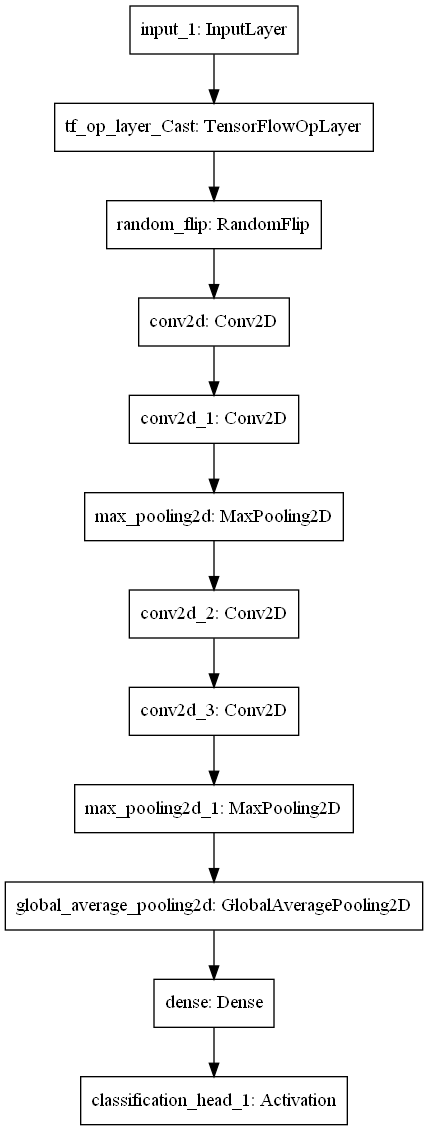

In [518]:
from tensorflow.keras.models import load_model
import autokeras as ak
# Make model
model = load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix")

from keras.utils import plot_model 
plot_model(model, to_file='C:/data/radiomics/model_pz_mix.png')

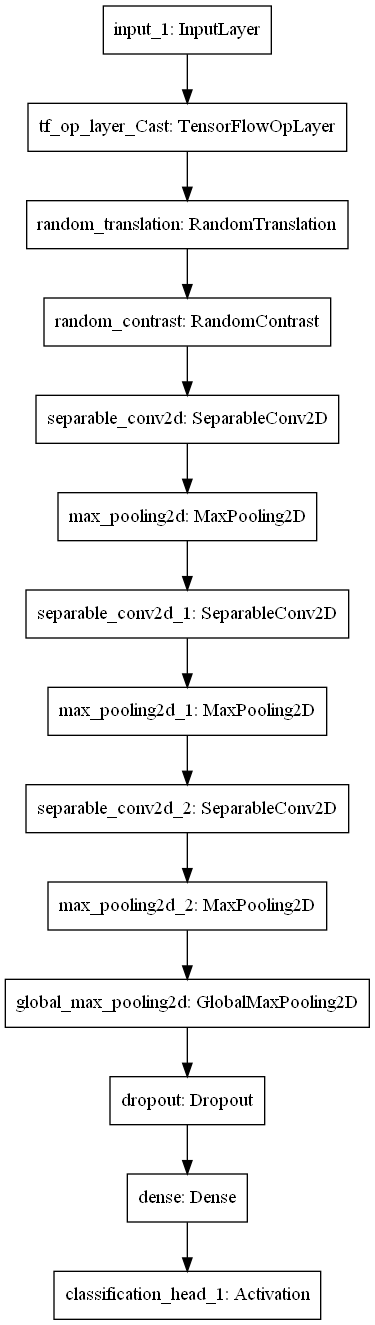

In [70]:
from tensorflow.keras.models import load_model
import autokeras as ak
# Make model
model = load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix")

from keras.utils import plot_model 
plot_model(model, to_file='C:/data/radiomics/model_cg_mix.png')

# Training Data Visualization
## CG Detector

Predicted Probability: [[0.97662956]]
Real Gleason Group: 3


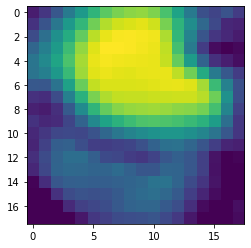

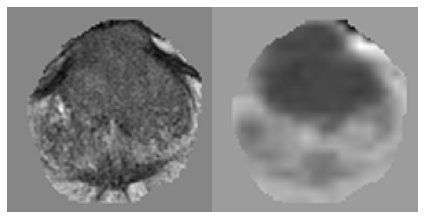

In [133]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 17
slice_i = 1 # MIM index - 1
# print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted Probability:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "separable_conv2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

In [151]:
label

array([3, 2, 1, 3, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 1, 4, 0, 0, 1, 0, 0, 3, 0, 2, 5, 0, 0, 1, 2, 0, 2, 3,
       1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 1, 2, 4,
       2, 4, 5, 5])

# Training Data Visualization
## PZ Detector

Predicted Probability: [[0.20080177]]
Real Gleason Group: 0


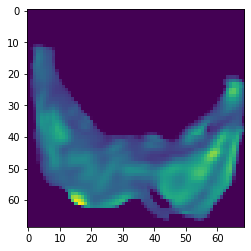

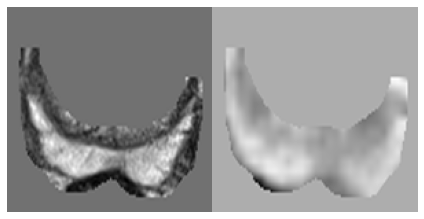

In [171]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 10
slice_i = 1 # MIM index - 1
# print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted Probability:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "conv2d_3"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

# Test on Private Data Named "WN" Series
## Challenge 1: Domain Drift: Different scanner and scanning parameters
## Challenge 2: No sub-region contour for Testing Data
### Finding 1: For PZ Detector, Shuffling Input with Choices of T2 and ADC does not Make a Difference

### Case with lower probability of Malignancy

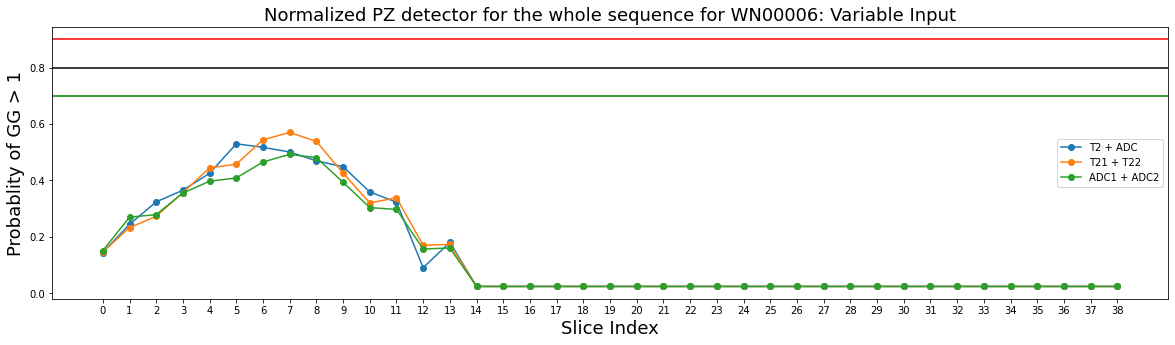

In [430]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 4
preds = np.zeros(39)
preds1 = np.zeros(39)
preds2 = np.zeros(39)
for slice_i in range(39):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    t22 = t2[:,:,slice_i+1,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    adc2 = adc[:,:,slice_i+1,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    t22 = np.expand_dims(t22, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    adc2 = np.expand_dims(adc2, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    img_array1 = np.concatenate((t21, t22), axis=-1)
    img_array1 = np.expand_dims(img_array1, axis=0)
    img_array2 = np.concatenate((adc1, adc2), axis=-1)
    img_array2 = np.expand_dims(img_array2, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model.predict(img_array1)
    preds2[slice_i] = model.predict(img_array2)
    
# print(preds)

x = np.arange(39)
y = preds
y1 = preds1
y2 = preds2
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "T2 + ADC")
plt.plot(x, y1, 'o-', label = "T21 + T22")
plt.plot(x, y2, 'o-', label = "ADC1 + ADC2")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ detector for the whole sequence for WN00006: Variable Input', fontsize=18)
plt.legend()
plt.show()

### Case with higher probability of Malignancy

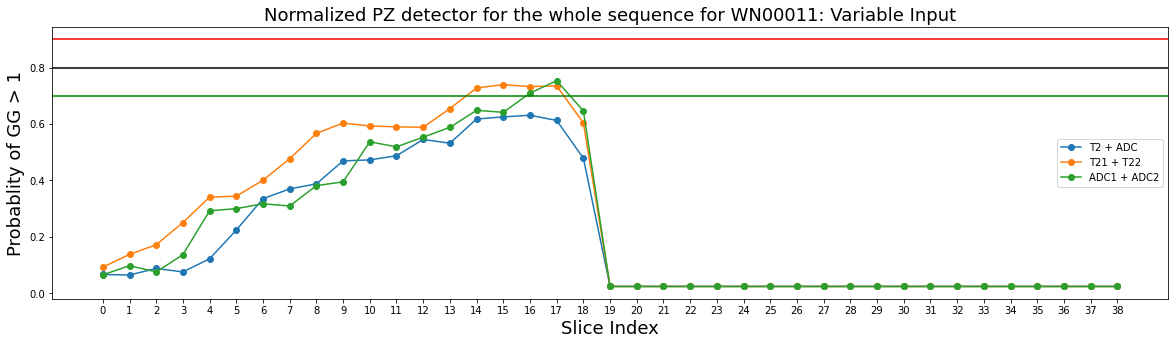

In [433]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 6
preds = np.zeros(39)
preds1 = np.zeros(39)
preds2 = np.zeros(39)
for slice_i in range(39):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    t22 = t2[:,:,slice_i+1,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    adc2 = adc[:,:,slice_i+1,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    t22 = np.expand_dims(t22, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    adc2 = np.expand_dims(adc2, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    img_array1 = np.concatenate((t21, t22), axis=-1)
    img_array1 = np.expand_dims(img_array1, axis=0)
    img_array2 = np.concatenate((adc1, adc2), axis=-1)
    img_array2 = np.expand_dims(img_array2, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model.predict(img_array1)
    preds2[slice_i] = model.predict(img_array2)
    
# print(preds)

x = np.arange(39)
y = preds
y1 = preds1
y2 = preds2
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "T2 + ADC")
plt.plot(x, y1, 'o-', label = "T21 + T22")
plt.plot(x, y2, 'o-', label = "ADC1 + ADC2")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ detector for the whole sequence for WN00011: Variable Input', fontsize=18)
plt.legend()
plt.show()

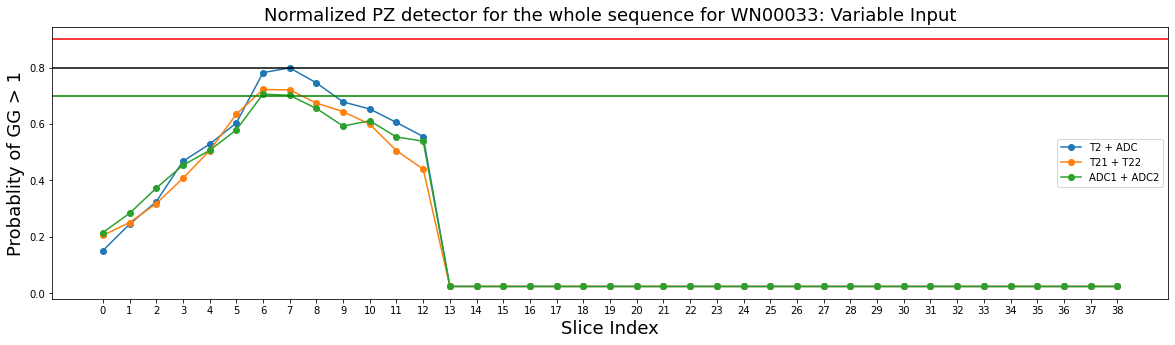

In [482]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 22
preds = np.zeros(39)
preds1 = np.zeros(39)
preds2 = np.zeros(39)
for slice_i in range(39):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    t22 = t2[:,:,slice_i+1,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    adc2 = adc[:,:,slice_i+1,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    t22 = np.expand_dims(t22, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    adc2 = np.expand_dims(adc2, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    img_array1 = np.concatenate((t21, t22), axis=-1)
    img_array1 = np.expand_dims(img_array1, axis=0)
    img_array2 = np.concatenate((adc1, adc2), axis=-1)
    img_array2 = np.expand_dims(img_array2, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model.predict(img_array1)
    preds2[slice_i] = model.predict(img_array2)
    
# print(preds)

x = np.arange(39)
y = preds
y1 = preds1
y2 = preds2
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "T2 + ADC")
plt.plot(x, y1, 'o-', label = "T21 + T22")
plt.plot(x, y2, 'o-', label = "ADC1 + ADC2")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ detector for the whole sequence for WN00033: Variable Input', fontsize=18)
plt.legend()
plt.show()

# Test on Private Data Named "WN" Series
## Plot Results of Both PZ Detector and CG Detector on the same Graph
### Finding 2: For CG Detector False Positive on Edging Slice 

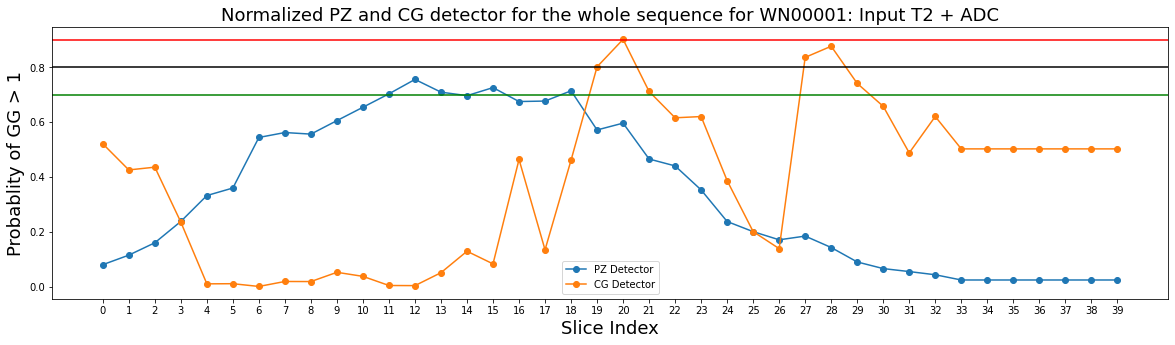

In [680]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 0
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00001: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

19
Predicted: [[0.8019319]]
Real Gleason Group: 3


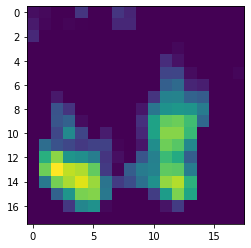

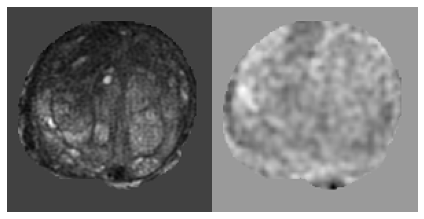

In [694]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 0
slice_i = 19 # MIM index - 1
print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "separable_conv2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

## CG Detector false Positive on Slice 29 - because of large background area

27
Predicted: [[0.83635885]]
Real Gleason Group: 3


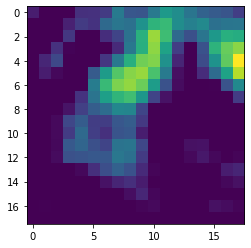

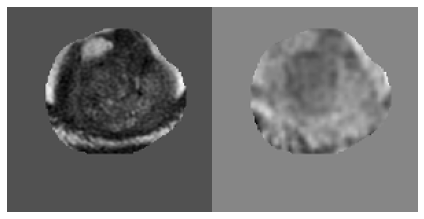

In [695]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 0
slice_i = 27 # MIM index - 1
print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "separable_conv2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

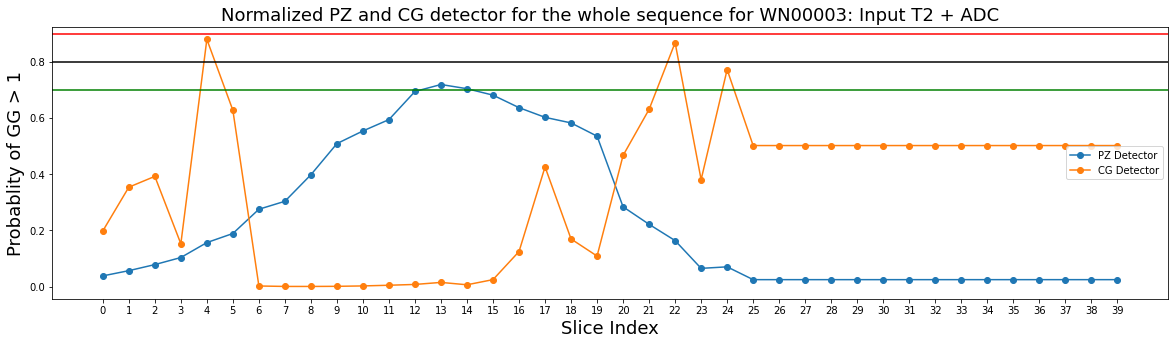

In [684]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 1
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00003: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

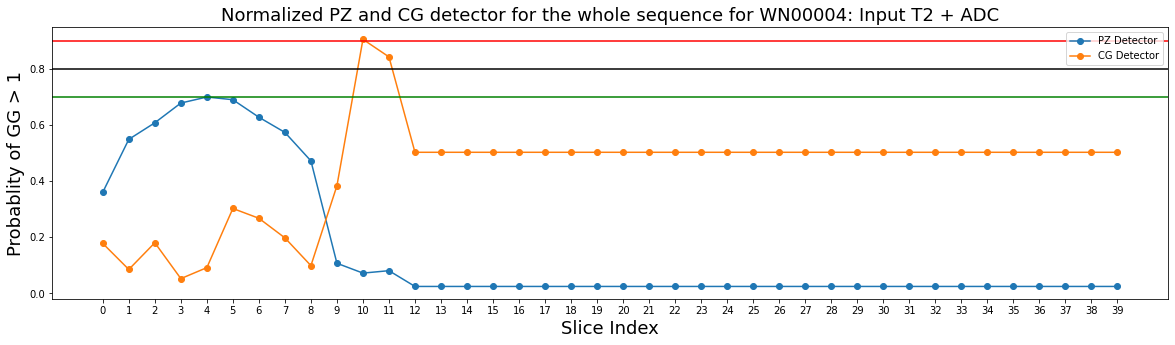

In [701]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 2
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00004: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

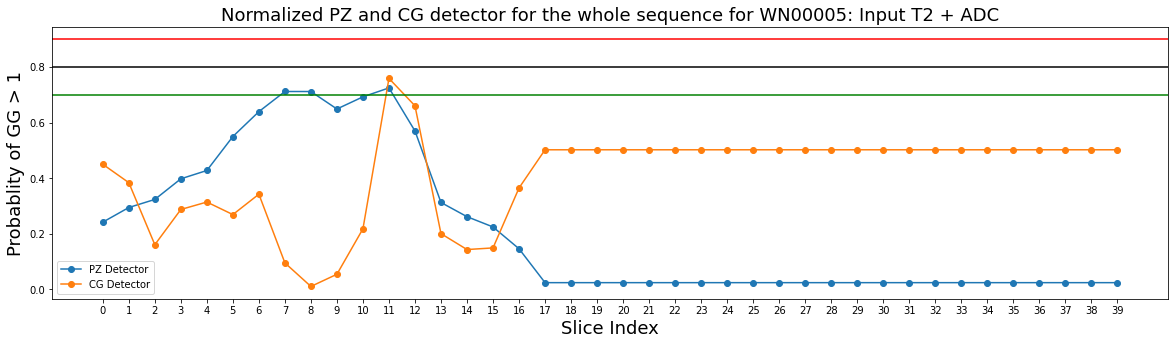

In [704]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 3
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00005: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

12
Predicted: [[0.660847]]
Real Gleason Group: 2


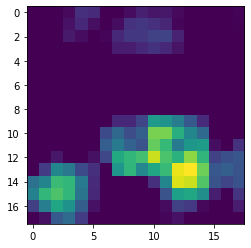

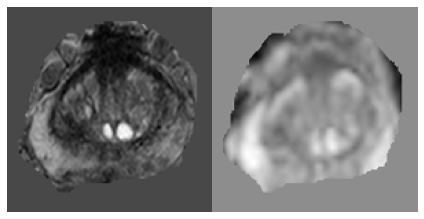

In [662]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 3
slice_i = 12 # MIM index - 1
print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "separable_conv2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

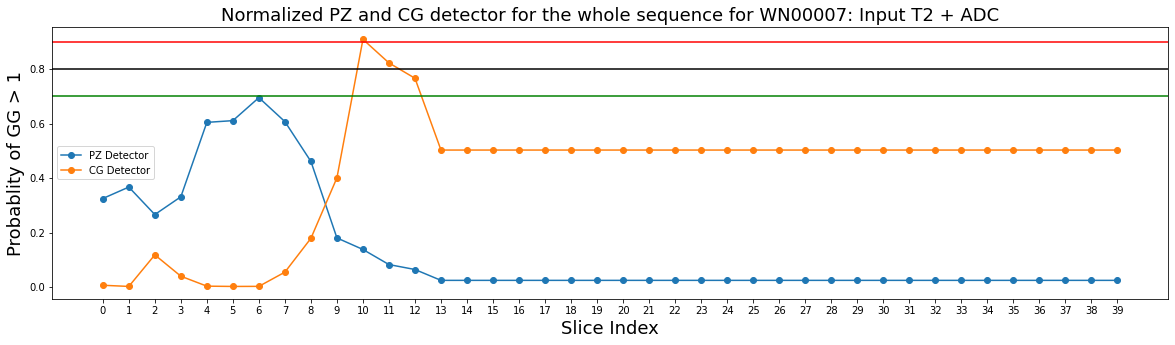

In [710]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 5
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00007: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

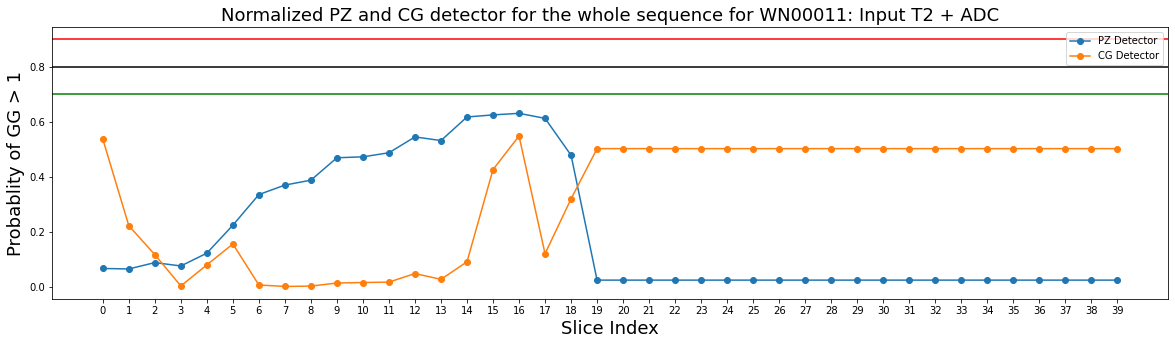

In [714]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 6
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00011: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

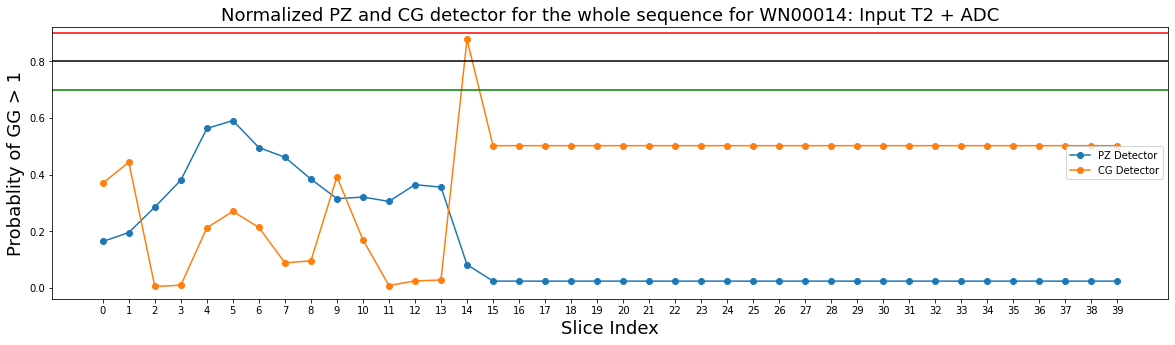

In [716]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 7
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00014: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

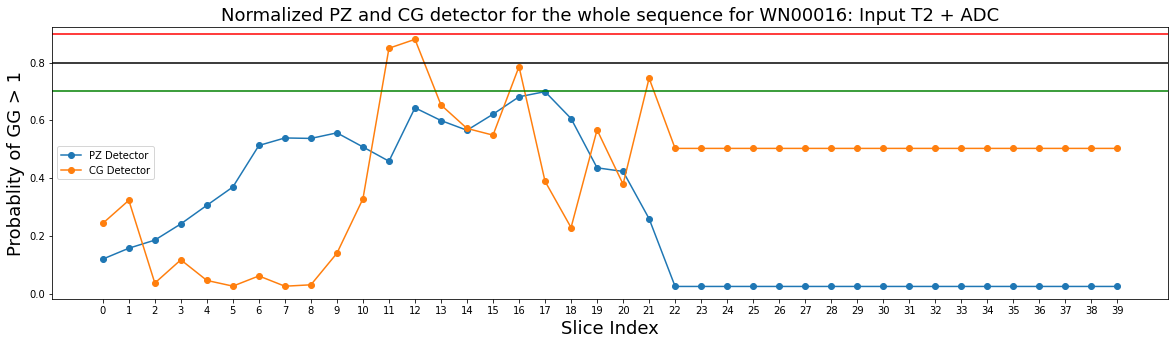

In [718]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 8
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00016: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

### Finding 3: CG Detector false positive on slice #16 for imperfect registration

In [172]:
# visualize testing

import autokeras as ak
from keras.utils import plot_model 
import tensorflow as tf

pt_i = 8
slice_i = 16 # MIM index - 1
print(slice_i)
l = label[pt_i]
# Prepare image
t21 = t2[:,:,slice_i,pt_i] # t2: 150 x 150 x 40 x 40
adc1 = adc[:,:,slice_i,pt_i]
t21 = np.expand_dims(t21, axis=-1)
adc1 = np.expand_dims(adc1, axis=-1)
img_array = np.concatenate((t21, adc1), axis=-1)
# print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
# print(img_array.shape)

# Make model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# plot_model(model, to_file='C:/data/radiomics/model.png')

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)
print("Real Gleason Group:", l)


last_conv_layer_name = "separable_conv2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.imshow(heatmap, cmap='gray')
plt.imshow(np.rot90(np.fliplr(heatmap)))
plt.show()

# Display image
fig, axs = plt.subplots(1, 2, gridspec_kw = {'wspace': 0, 'hspace':0})
axs[0].imshow(np.rot90(np.fliplr(img_array[0,:,:,0])), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(np.rot90(np.fliplr(img_array[0,:,:,1])), cmap='gray')
axs[1].set_axis_off()


plt.tight_layout()
plt.show()

16


IndexError: index 16 is out of bounds for axis 2 with size 3

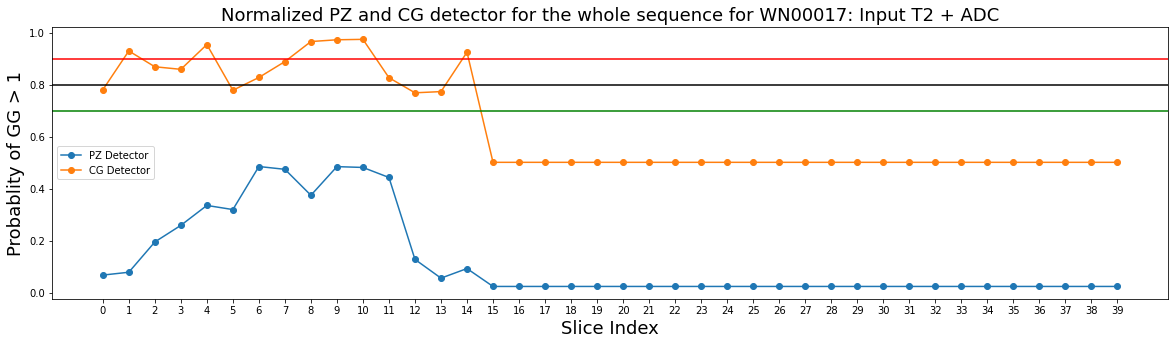

In [724]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 9
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00017: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

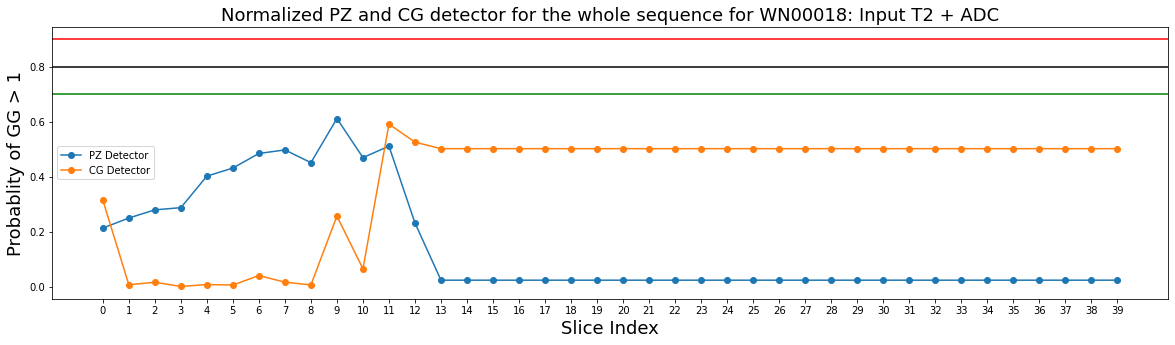

In [725]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 10
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00018: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

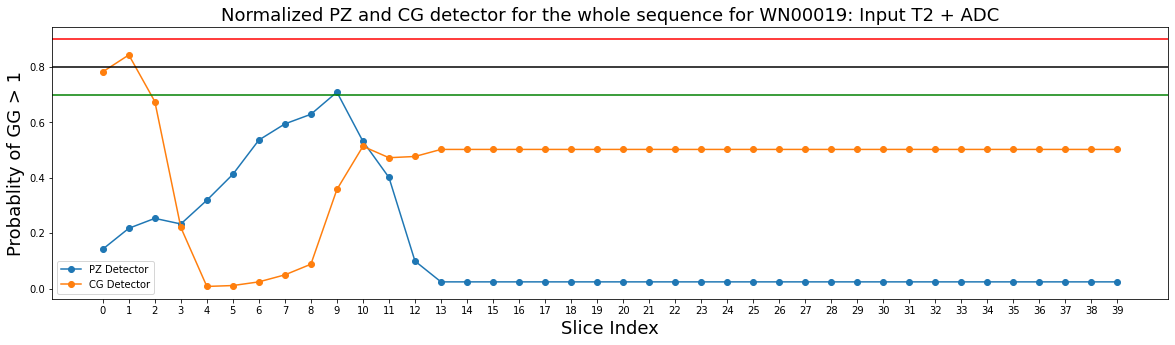

In [726]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 11
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00019: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

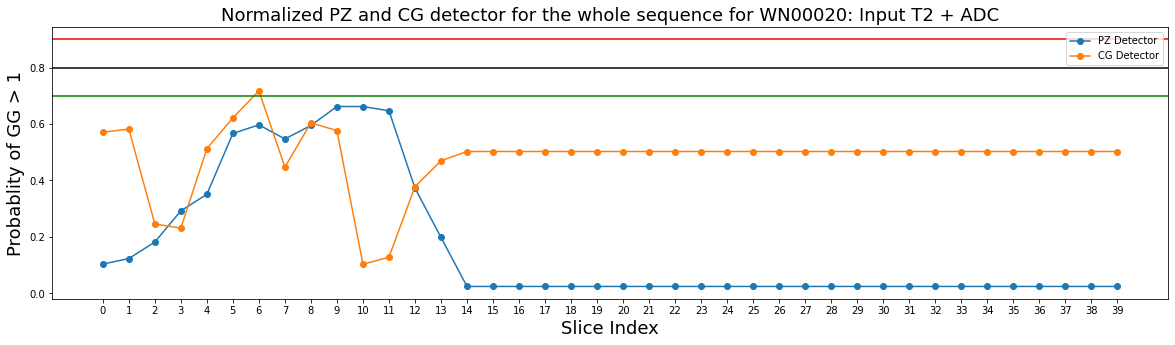

In [727]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 12
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00020: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

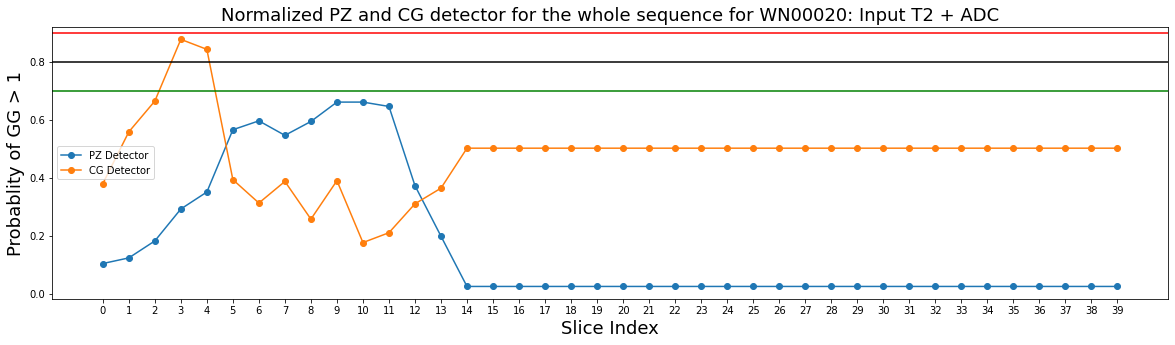

In [24]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 12
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array1 = np.concatenate((adc1, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    img_array1 = np.expand_dims(img_array1, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array1)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00020: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

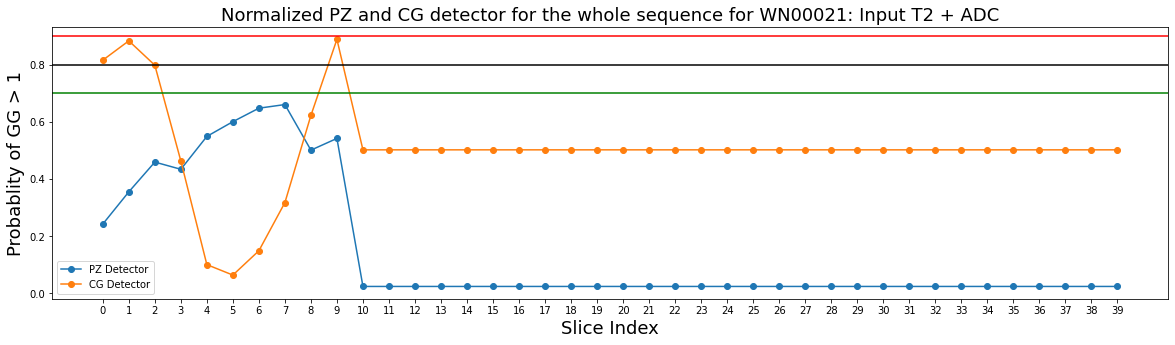

In [728]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 13
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00021: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

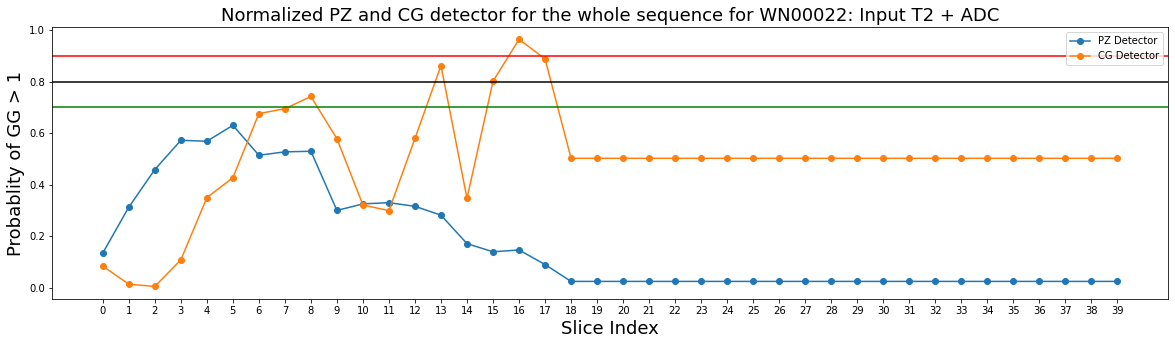

In [729]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 14
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00022: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

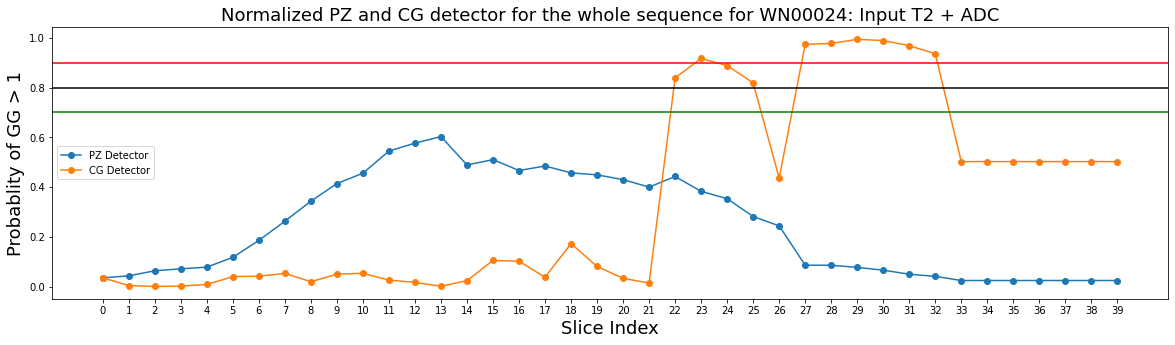

In [730]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 15
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00024: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

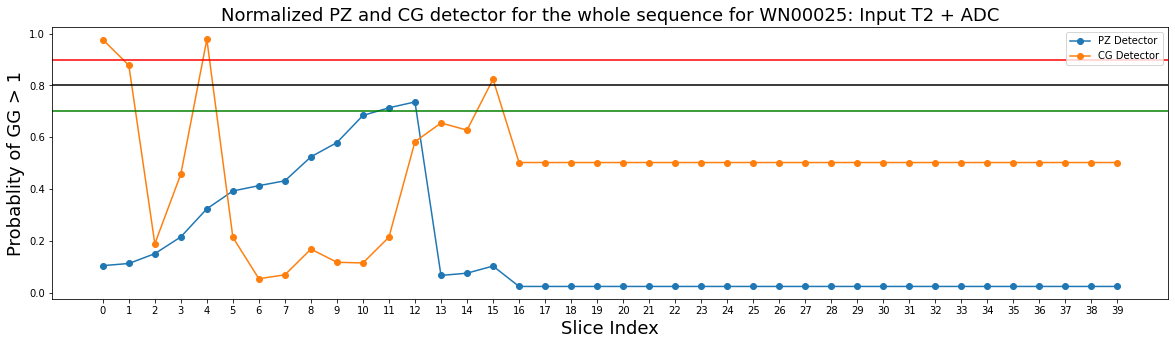

In [731]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 16
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00025: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

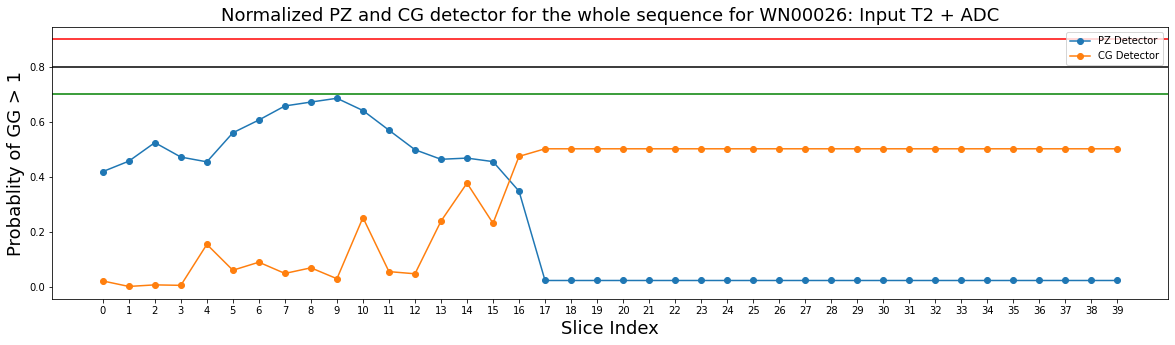

In [732]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 17
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00026: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

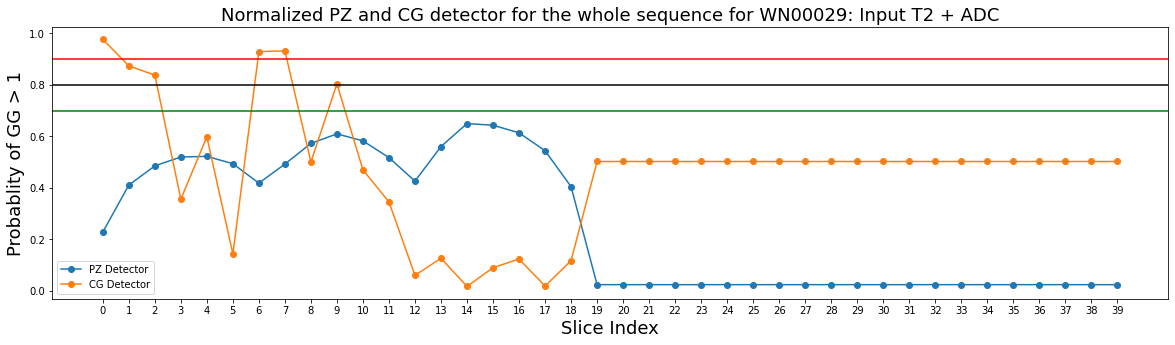

In [733]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 18
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00029: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

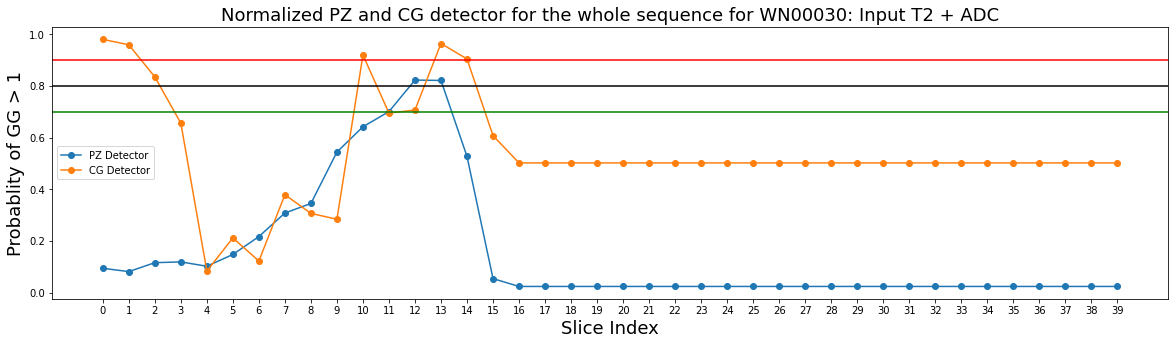

In [734]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 19
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00030: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

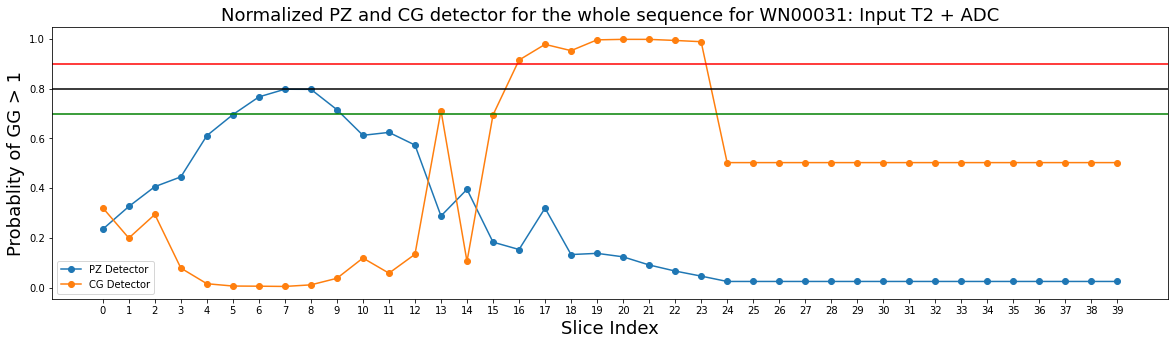

In [735]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 20
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00031: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

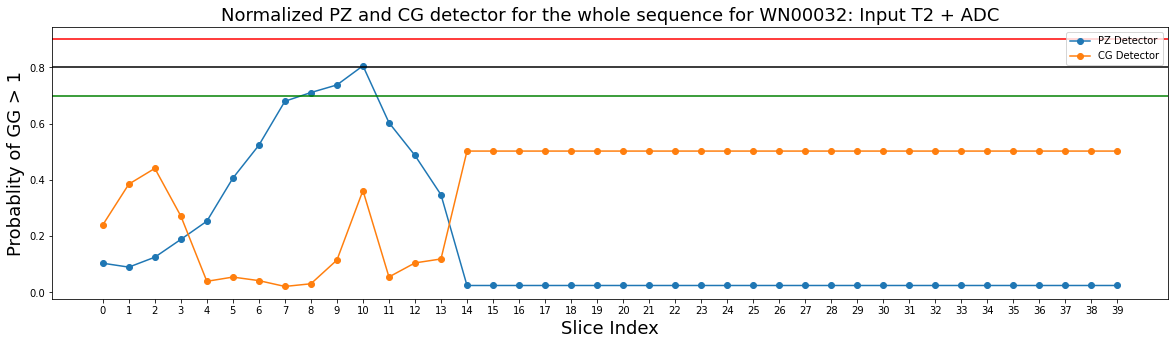

In [736]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 21
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00032: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

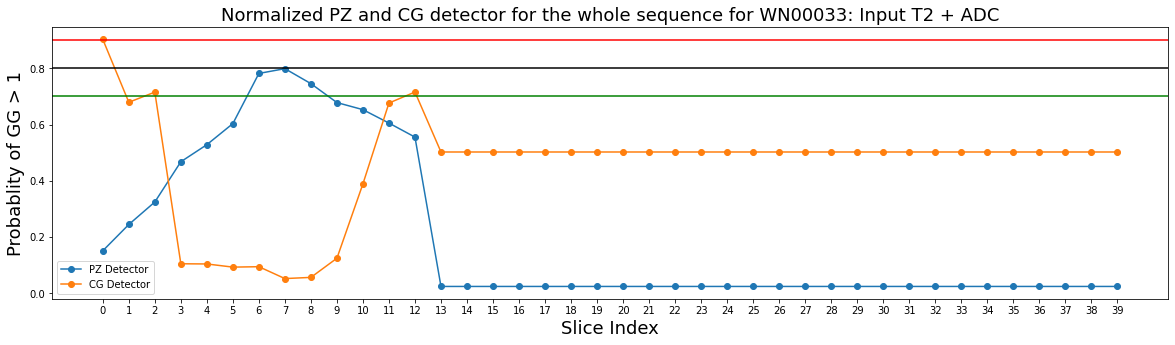

In [737]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 22
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00033: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

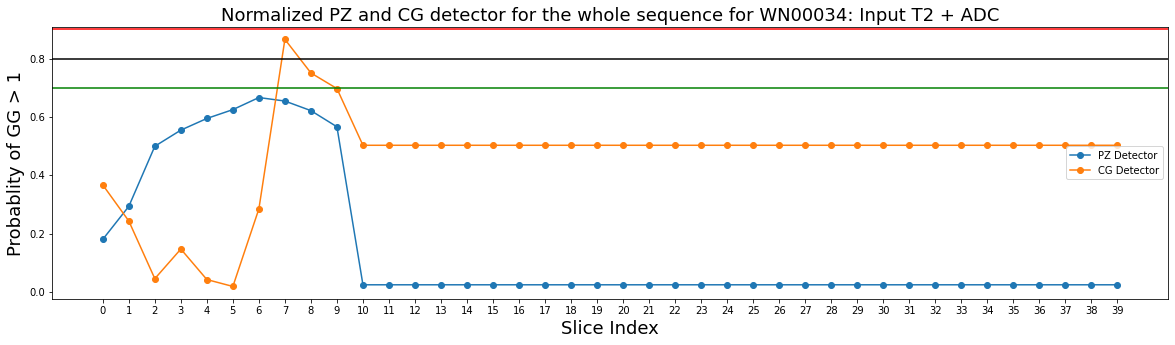

In [738]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 23
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00034: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

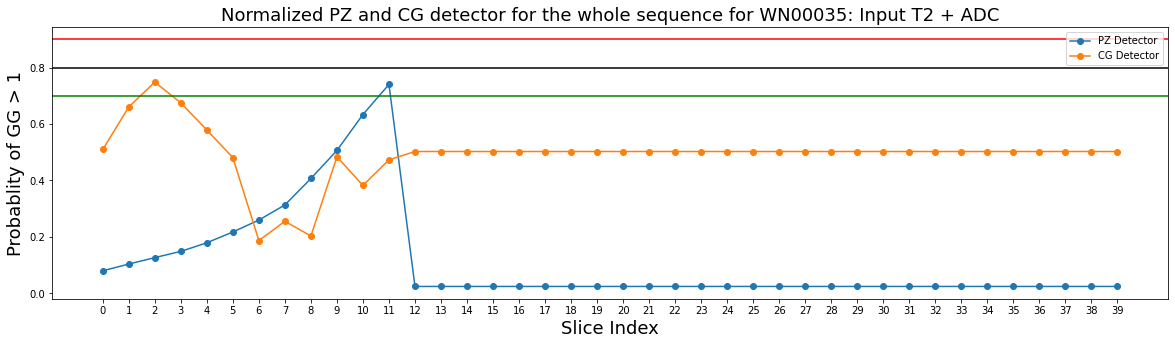

In [739]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 24
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00035: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

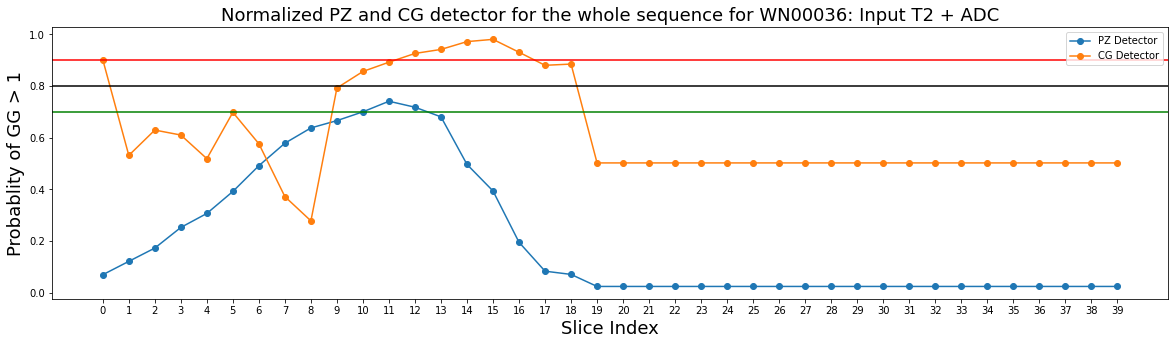

In [740]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 25
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00036: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

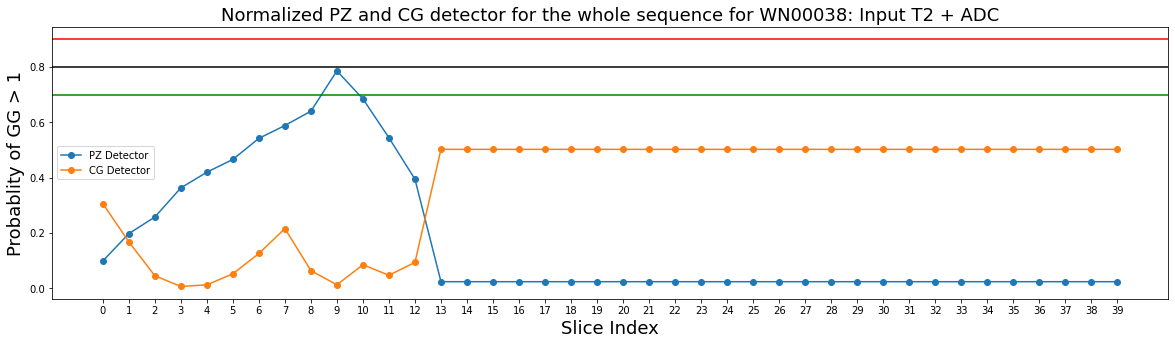

In [741]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 26
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00038: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

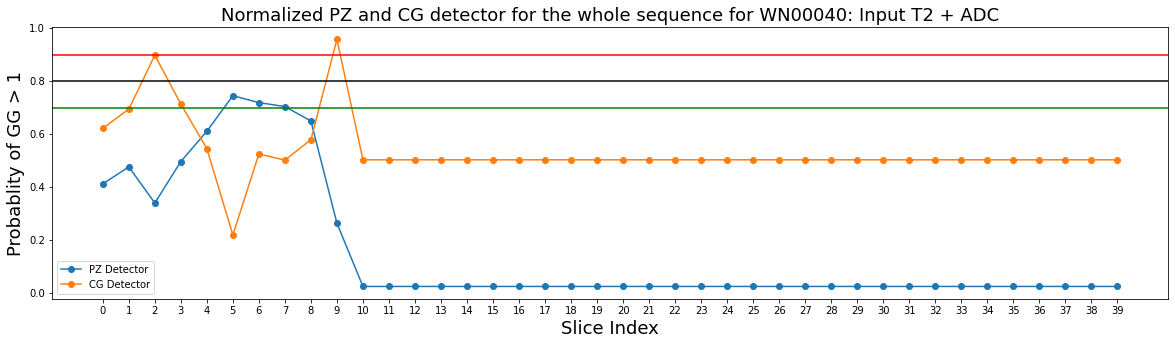

In [742]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 27
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00040: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

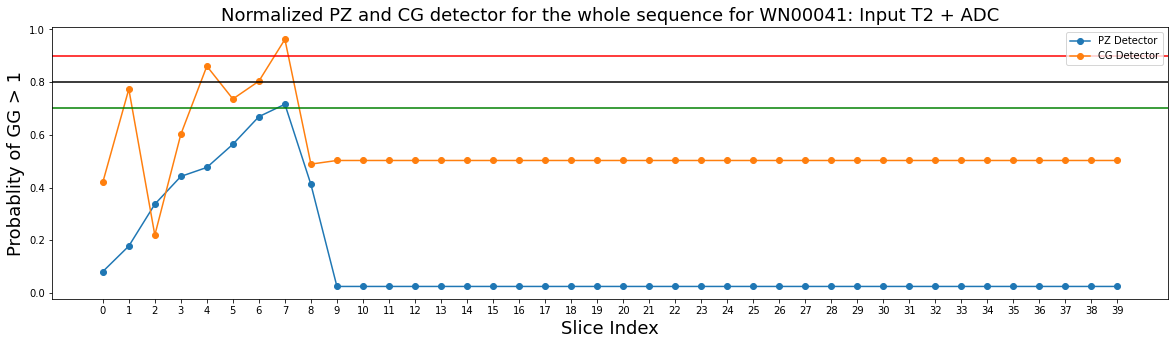

In [743]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 28
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00041: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

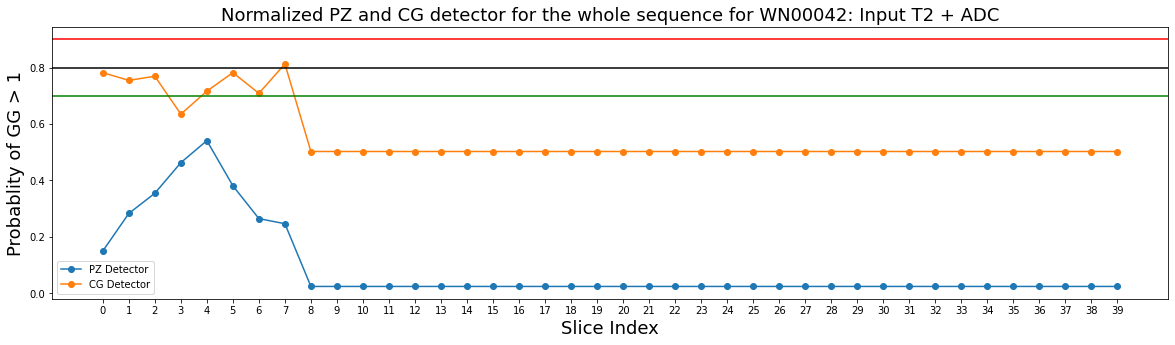

In [744]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 29
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00042: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

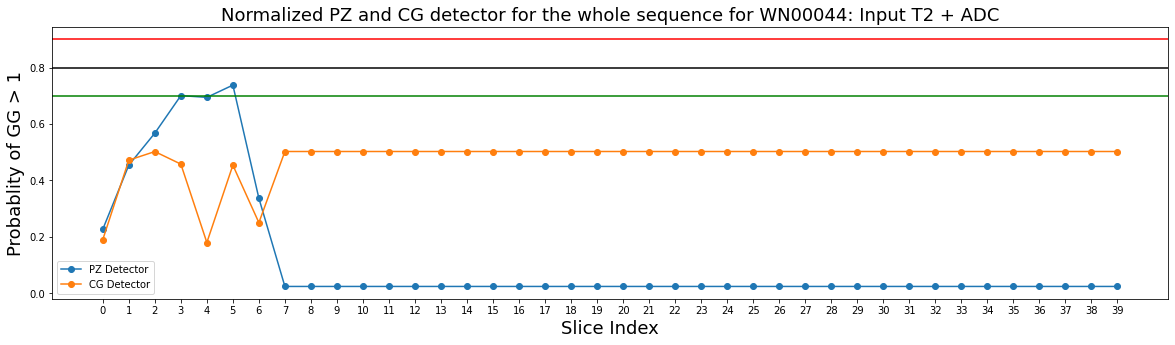

In [745]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 30
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00044: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

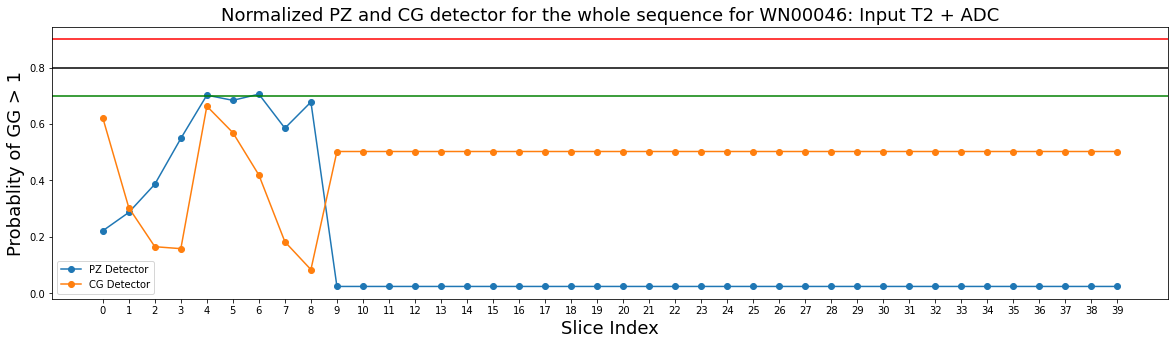

In [746]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 31
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00046: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

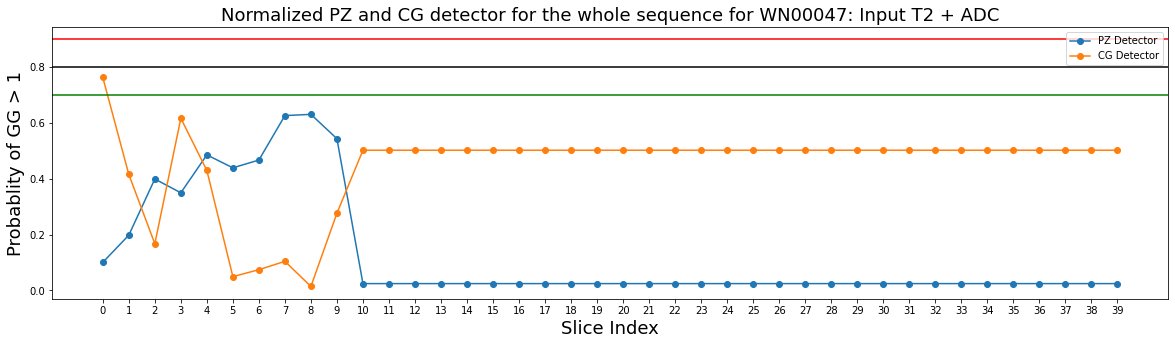

In [747]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 32
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00047: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

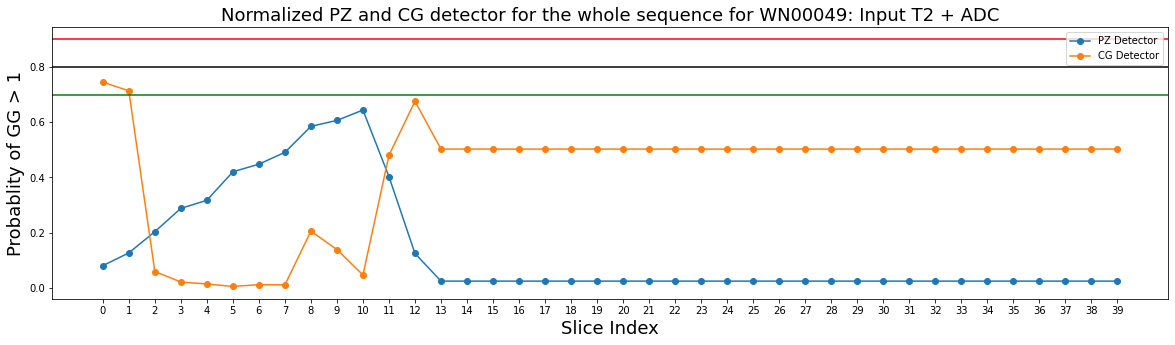

In [748]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 33
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00049: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

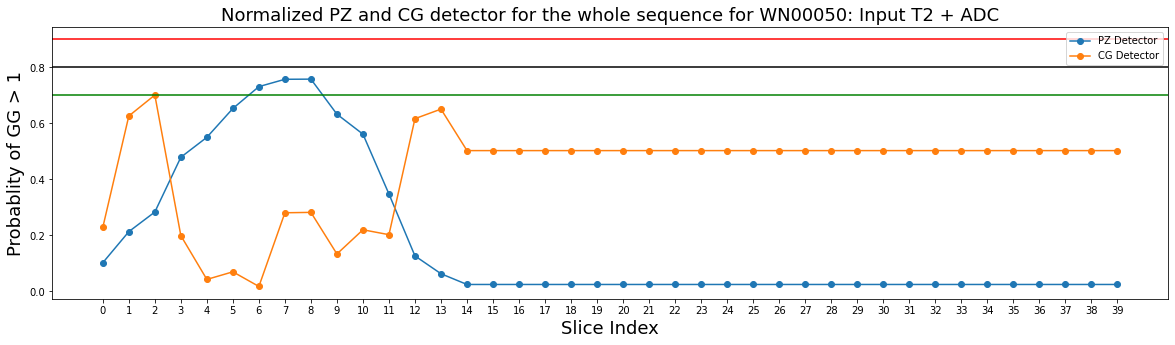

In [749]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 34
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00050: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

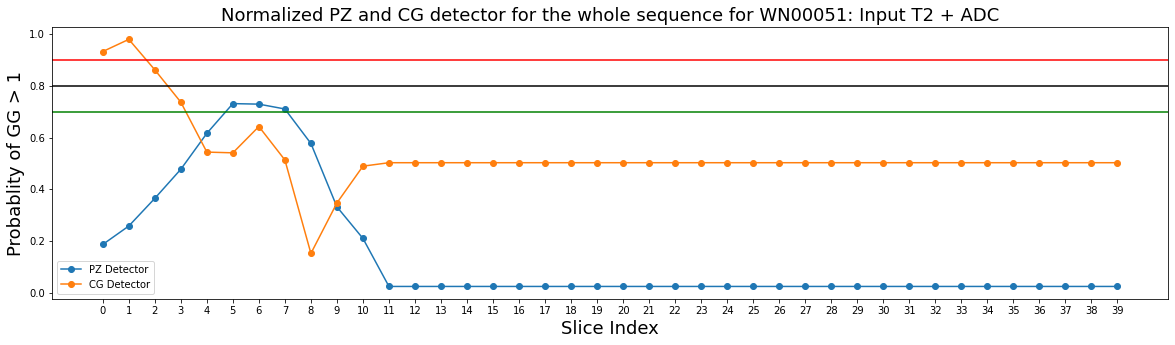

In [750]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 35
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00051: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

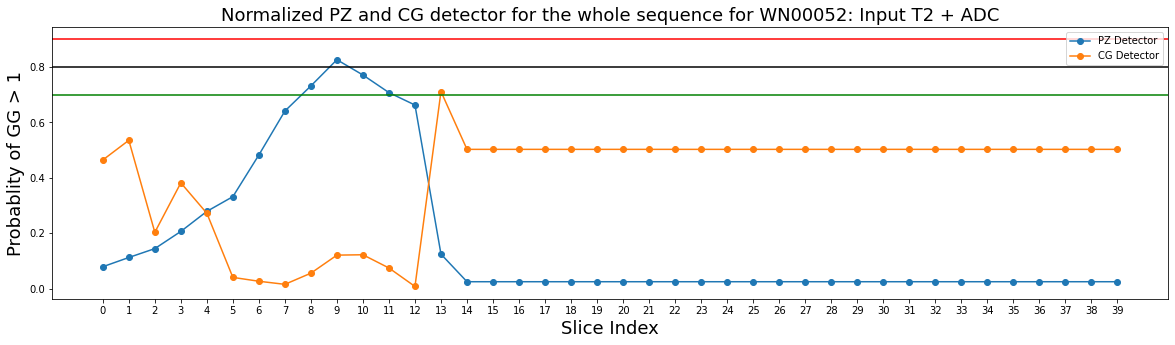

In [751]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 36
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00052: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

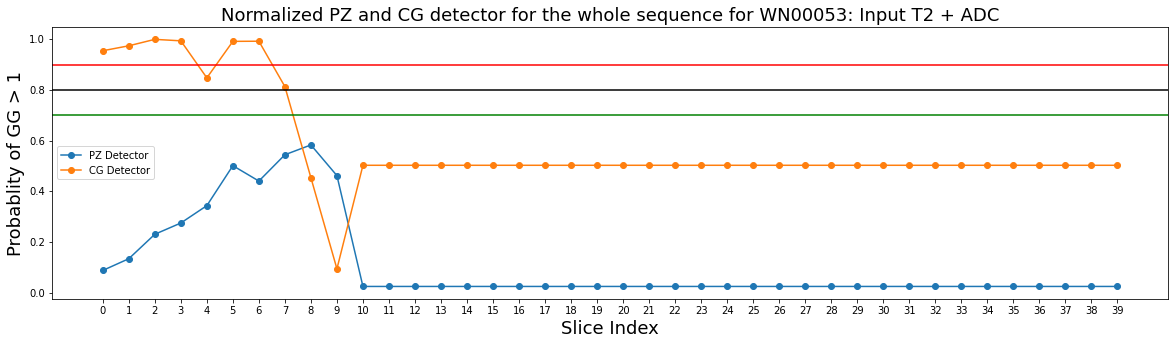

In [752]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 37
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00053: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

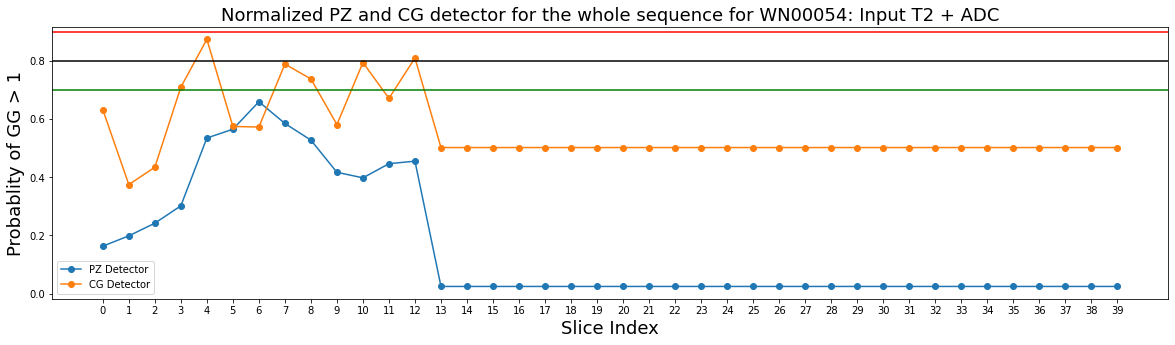

In [753]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 38
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00054: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()

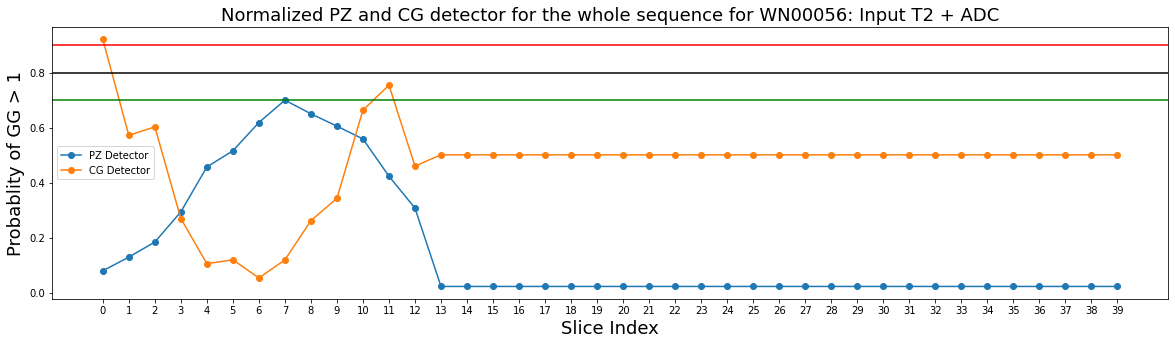

In [754]:
# Load model
model = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/pz/mix", custom_objects=ak.CUSTOM_OBJECTS)
model1 = keras.models.load_model("C:/data/radiomics/saved_model/binary/01vs2345/cg/mix", custom_objects=ak.CUSTOM_OBJECTS)
#
pt_i = 39
preds = np.zeros(40)
preds1 = np.zeros(40)
for slice_i in range(40):
    # Prepare image
    
    t21 = t2[:,:,slice_i,pt_i]
    adc1 = adc[:,:,slice_i,pt_i]
    t21 = np.expand_dims(t21, axis=-1)
    adc1 = np.expand_dims(adc1, axis=-1)
    img_array = np.concatenate((t21, adc1), axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    preds[slice_i] = model.predict(img_array)
    preds1[slice_i] = model1.predict(img_array)
    
# print(preds)

x = np.arange(40)
y = preds
yc = preds1
  
# second plot with x1 and y1 data
plt.figure(figsize=(20, 5))
plt.plot(x, y, 'o-', label = "PZ Detector")
plt.plot(x, yc, 'o-', label = "CG Detector")
plt.axhline(y=0.7, color = 'g') 
plt.axhline(y=0.8, color = 'k') 
plt.axhline(y=0.9, color = 'r') 
plt.xlabel("Slice Index", fontsize=18)
plt.xticks(x)
plt.ylabel("Probablity of GG > 1", fontsize=18)
plt.title('Normalized PZ and CG detector for the whole sequence for WN00056: Input T2 + ADC', fontsize=18)
plt.legend()
plt.show()